In [1]:
import matplotlib.pyplot as plt
plt.style.use("../styles/hda.mplstyle")

(chp-vector-space-model)=
# Exploring Texts using the Vector Space Model

(sec-vector-space-model-introduction)=
## Introduction

Reasoning about space is easy and straightforward in the real world: we all have intuitive
estimates as to how far two places are apart in everyday life and we are used to planning
our traveling routes accordingly. We know how to look up the location of places on digital
maps online or even in an old-fashioned atlas. We understand how a place's coordinates, in
terms of longitude and latitude, can capture that spot's exact location on earth. We grasp
how such data can readily be used to retrieve nearby locations, i.e., the concept of a
"neighborhood". Even for entirely fictional universes, such as Middle Earth, research has
demonstrated that readers build up similar ideas about the spatial structures that are
encoded in literary narratives (cf. {cite:t}`louwerseEA2012,louwerse_sterling:2012`). In this chapter, we explore to which extent this sort of spatial reasoning can be applied to textual data: is it possible to think of texts as mere points in a space, that have exact coordinates that allow us to calculate how far two texts are separated from one another? Is it feasible to plot entire corpora onto abstract maps and inspect their internal structure?

In order to study texts in a spatial fashion, we need a representation that is able to model the individual characteristics of texts using a "coordinate system"---just like places in the real world also have a unique set of coordinates that describe their properties across different dimensions (e.g., longitude, latitude, but also altitude). To this end, we will introduce the <span class="index">*vector space model*</span>, a simple, yet powerful representation strategy that helps us to encode textual documents into the concrete numbers (or "coordinates") that are necessary for further processing. The text-as-maps metaphor will help the reader understand why <span class="index">geometry</span>, the mathematical study of (points in) space, is so central to computational text analysis nowadays (as it is in this chapter). Just as with the locations on real maps, geometry offers us established methodologies to explore relations, similarities, and differences between texts. Interestingly, these methods typically require relatively few assumptions about what textual properties might precisely be salient in a given document.

Why would such a spatial perspective on (textual) data in fact be desirable? To illustrate the potential of this approach, this chapter will work with a simple, but real-world example throughout, namely a corpus of French-language drama of the Classical Age and the Enlightenment Age (seventeenth--eighteenth century), that has been quantitatively explored by {cite:t}`schoech:2017` in a paper that will function as our baseline in this chapter. We will focus on plays drawn from three well-studied subgenres: "Tragédie", "Comédie", and "Tragi-comédie". Readers, even those not familiar at all with this specific literature, will have very clear expectations as to which texts will be represented in these genres, because of these generic genre labels. The same readers, however, may lack grounds to explain this similarity formally and express their natural intuition in more concrete terms. We will explore how the vector space model can help us understand the differences between these subgenres from a quantitative, geometric point of view. What sort of lexical differences, if any, become apparent when we plot these different genres as spatial data? Does the subgenre of "Tragi-comédies" display a lexical mix of both "Comédies" and "Tragédies" markers or is it relatively closer to one of these constituent genres?

The first section of this chapter (section {ref}`sec-vector-space-model-vector-space-model`) elaborates on several low-level preprocessing steps that can be taken when preparing a real-life corpus for numerical processing. It also discusses the ins-and-outs of converting a corpus into a bag-of-words representation, while critically reflecting on the numerous design choices that we have in implementing such a model in actual code. In section {ref}`sec-vector-space-model-mapping-genre`, then, these new insights are combined, as well as those from chapter {ref}`chp-getting-data`, in a focused case study about the dramatic texts introduced above. To efficiently represent and work with texts represented as vectors, this chapter uses Python's main numerical library "<span class="index">NumPy</span>" (section {ref}`sec-vector-space-model-numpy-intro`), which is at the heart of many of Python's data analysis libraries {cite:p}`walt2011numpy`. For readers not yet thoroughly familiar with this package, we offer an introductory overview at the end of this chapter, which can safely be skipped by more proficient coders. Finally, this chapter introduces the notion of a "nearest neighbor" (section {ref}`sec-vector-space-model-nearest-neighbors`) and explains how this is useful for studying the collection of French drama texts.

(sec-vector-space-model-vector-space-model)=
## From Texts to Vectors

As the name suggests, a <span class="index">bag-of-words</span> representation models a
text in terms of the individual words it contains, or, put differently, at the lexical
level. This representation discards any information available in the sequence in which
words appear. In the bag-of-words model, word sequences such as "the boy ate the fish",
"the fish ate the boy", and "the ate fish boy the" are all equivalent. While linguists
agree that syntax is a vital part of human languages, representing texts as bags of words
heedlessly ignores this information: it models texts by simply counting how often each
unique word occurs in them, regardless of their order or position in the original document
(see chp. 6 in {cite:t}`jurafskyinpressspeech`, and {cite:t}`sebastiani:2002`). While disgarding this information seems, at first glance, limiting in the extreme, representing texts in terms of their word frequencies has proven its usefulness over decades of use in information retrieval and quantitative text analysis.

When using the <span class="index">vector space model</span>, a <span
class="index">corpus</span>---a collection of documents, each represented as a bag of
words---is typically represented as a matrix, in which each row represents a document from
the collection, each column represents a word from the collection's <span
class="index">vocabulary</span>, and each cell represents the frequency with which a
particular word occurs in a document. In this tabular setting, each row is interpretable
as a <span class="index">*vector*</span> in a vector space. A matrix arranged in this way
is often called a *document-term matrix*---or *term-document matrix* when rows are
associated with words and documents are associated with columns. An example of a <span class="index">document-term matrix</span> is shown in {numref}`tbl-document-term-matrix`.

```{table} Example of a vector space representation with four documents (rows) and a vocabulary of four words (columns). For each document the table lists how often each vocabulary item occurs.
:name: tbl-document-term-matrix

|       | _roi_ | _ange_ | _sang_ | _perdu_ |
|-------|-------|--------|--------|---------|
| $d_1$ |     1 |      2 |     16 |      21 |
| $d_2$ |     2 |      2 |     18 |      19 |
| $d_3$ |    35 |     41 |      0 |       2 |
| $d_4$ |    39 |     55 |      1 |       0 |
```

In this table, each document $d_i$ is represented as a vector, which, essentially, is a list of numbers---word frequencies in our present case. A <span class="index">vector space</span> is nothing more than a collection of numerical vectors, which may, for instance, be added together and multiplied by a number. Documents represented in this manner may be compared in terms of their *coordinates* (or *components*). For example, by comparing the four documents on the basis of the second coordinate, we observe that the first two documents ($d_1$ and $d_2$) have similar counts, which might be an indication that these two documents are somehow more similar. To obtain a more accurate and complete picture of document similarity, we would like to be able to compare documents more holistically, using *all* their components. In our example, each document represents a point in a four-dimensional vector space. We might hypothesize that similar documents use similar words, and hence reside close to each other in this space. To illustrate this, we demonstrate how to visualize the documents in space using the first and third components.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'sans-serif' not found because none of the following families were found: "Roboto Condensed Regular"


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'sans-serif' not found because none of the following families were found: "Roboto Condensed Regular"


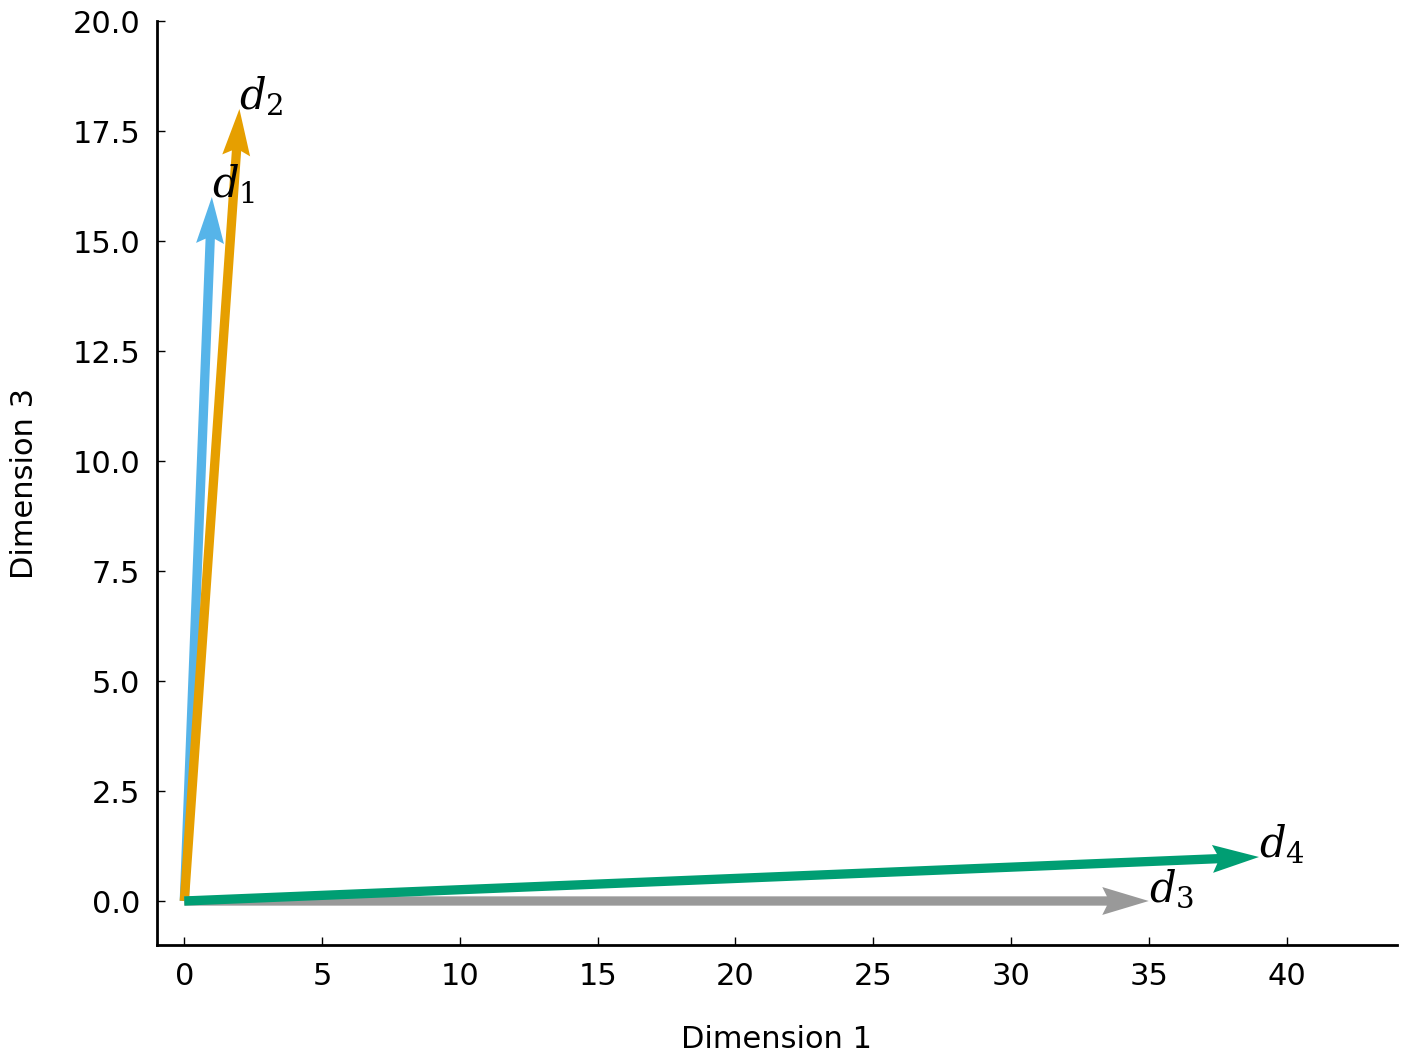

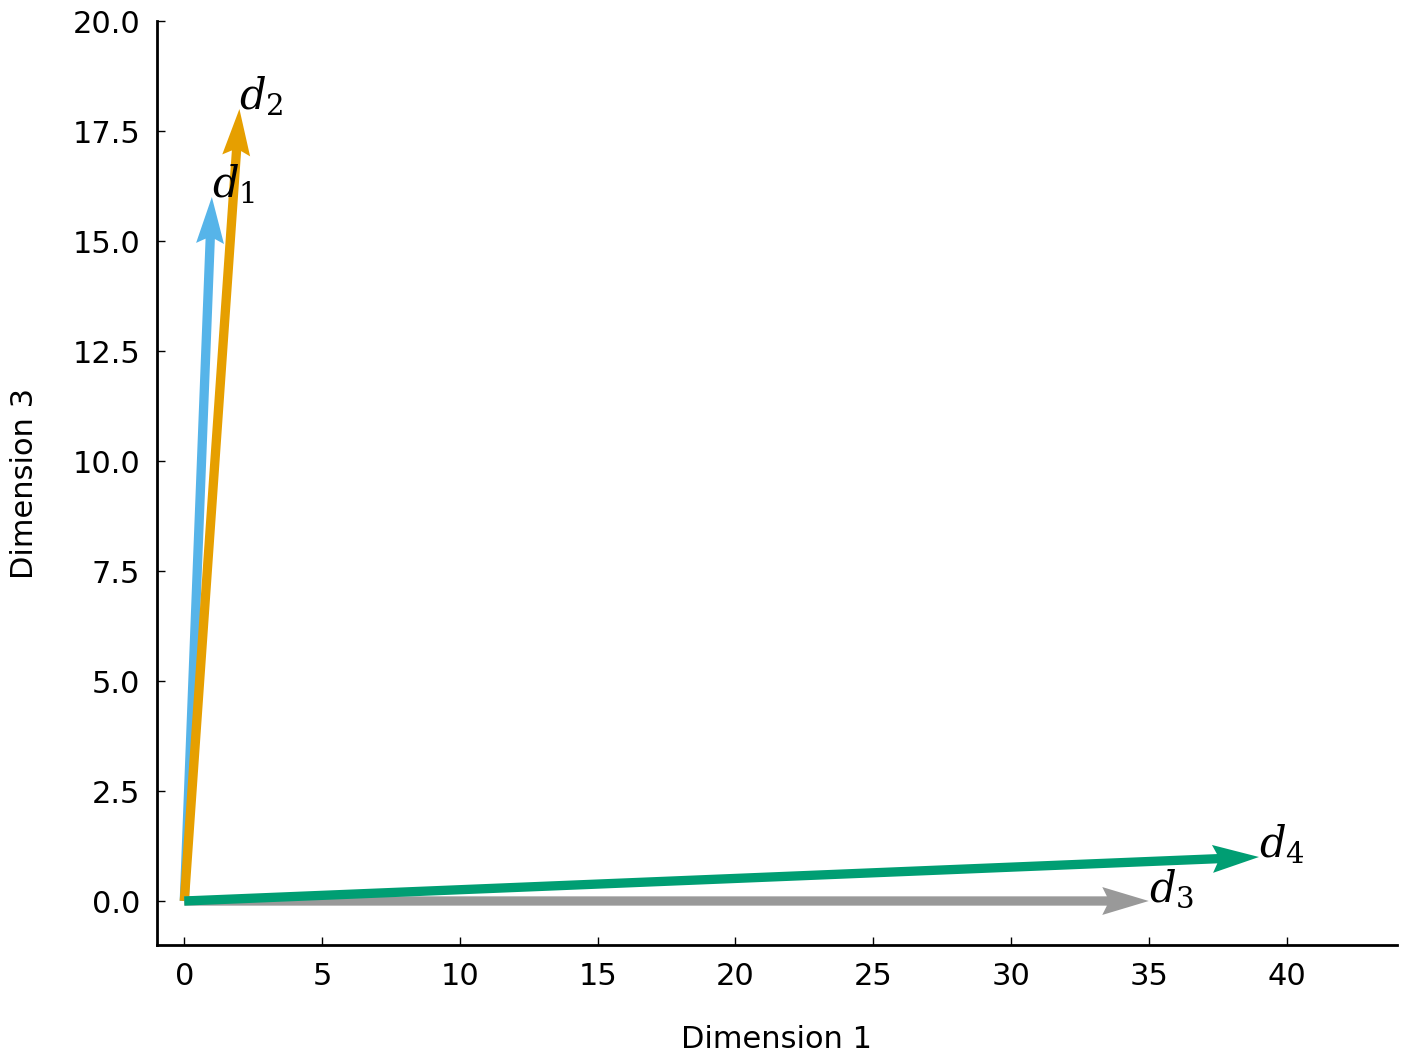

In [2]:
import numpy as np
import matplotlib.pyplot as plt

document_term_matrix = np.array([[1, 16], [2, 18], [35, 0], [39, 1]])
labels = '$d_1$', '$d_2$', '$d_3$', '$d_4$'
fig, ax = plt.subplots()
plt.quiver([0, 0, 0, 0], [0, 0, 0, 0],
           document_term_matrix[:, 0], document_term_matrix[:, 1],
           color=["C0", "C1", "C2", "C3"], angles='xy', scale_units='xy', scale=1)
for i, label in enumerate(labels):
    plt.annotate(label, xy=document_term_matrix[i], fontsize=15)
plt.ylim(-1, 20); plt.xlim(-1, 44)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 3");

from myst_nb import glue
glue("doc_in_space", fig, display=False)

```{glue:figure} doc_in_space
---
name: fig-vector-space-model-documents-in-space
---

Demonstration of four documents (represented as vectors) residing in a two-dimensional space.
```

The plot in {numref}`fig-vector-space-model-documents-in-space` makes visually clear that documents $d_1$ and $d_2$ occupy neighboring positions in space, both far away from the other two documents. As the number of dimensions increases (collections of real-world documents typically have vocabularies with tens of thousands of unique words), it will become unfeasible to visually analyze the similarity between documents. To quantify the distance (or similarity) between two documents in high-dimensional space, we can employ <span class="index">distance function</span>s or metrics, which express the distance between two vectors as a non-negative number. The implementation and application of such <span class="index">distance metric</span>s will be discussed in section {ref}`sec-vector-space-model-distance-metrics`.

```{figure} images/bow.png
---
name: fig-vector-space-steps
---

Extracting a document-term matrix from a collection of texts.
```

Having a basic theoretical understanding of the vector space model, we move on to the practical part of implementing a procedure to construct a <span class="index">document-term matrix</span> from plain text. In essence, this involves three consecutive steps. In the first step, we determine the <span class="index">vocabulary</span> of the collection, optionally filtering the vocabulary using information about how often each unique word (type) occurs in the corpus. The second step is to count how often each element of the vocabulary occurs in each individual document. The third and final step takes the bags of words from the second step and builds a document-term matrix. The right-most table in {numref}`fig-vector-space-steps` above represents the document-term matrix resulting from this procedure. The next section will illustrate how this works in practice.

(sec-vector-space-model-text-processing)=
### Text preprocessing

A common way to represent text documents is to use strings (associated with Python's `str` type). Consider the following code block, which represents the ten mini-documents from the figure above as a list of strings.

In [3]:
corpus = ["D'où me vient ce désordre, Aufide, et que veut dire",
          "Madame, il était temps qu'il vous vînt du secours:",
          "Ah! Monsieur, c'est donc vous?",
          "Ami, j'ai beau rêver, toute ma rêverie",
          "Ne me parle plus tant de joie et d'hyménée;",
          "Il est vrai, Cléobule, et je veux l'avouer,",
          "Laisse-moi mon chagrin, tout injuste qu'il est;",
          "Ton frère, je l'avoue, a beaucoup de mérite;",
          "J'en demeure d'accord, chacun a sa méthode;",
          'Pour prix de votre amour que vous peignez extrême,']

In order to construct a <span class="index">bag-of-words</span> representation of each "text" in this corpus, we must first process the strings into distinct words. This process is called "<span class="index">tokenization</span>" or "<span class="index">word segmentation</span>". A naive tokenizer might split documents along (contiguous) whitespace. In Python, such a tokenizer can be implemented straightforwardly by using the string method `split()`. As demonstrated in the following code block, this method employs a tokenization strategy in which tokens are separated by one or more instances of whitespace (e.g., spaces, tabs, newlines):

In [4]:
document = corpus[2]
print(document.split())

['Ah!', 'Monsieur,', "c'est", 'donc', 'vous?']


The tokenization strategy used often has far-reaching consequences for the composition of the final document-term matrix. If, for example, we decide not to lowercase the words, _Il_ ('he') is considered to be different from *il*, whereas we would normally consider them to be instances of the same word *type*. An equally important question is whether we should incorporate or ignore punctuation marks. And what about contracted word forms? Should _qu'il_ be restored to _que_ and *il*?

Such choices may appear simple, but they may have a strong influence on the final text representation, and, subsequently, on the analysis based on this representation. Unfortunately, it is difficult to provide a recommendation here apart from advising that <span class="index">tokenization</span> procedures be carefully documented. To illustrate the complexity, consider the problem of modeling thematic differences between texts. For this problem, certain linguistic markers such as punctuation might not be relevant. However, the same linguistic markers might be of a crucial importance to another problem. In authorship attribution, for example, it has been demonstrated that punctuation is one of the strongest predictors of authorial identity {cite:p}`grieve2007`. We already spoke about lowercasing texts, which is another common <span class="index">preprocessing</span> step. Here as well, we should be aware that it has certain consequences for the final text representation. For instance, it complicates identifying proper nouns or the beginnings of sentences at a later stage in an analysis. Sometimes reducing the information recorded in a text representation is motivated by necessity: researchers may only have a fixed budget of computational resources available to analyze a corpus.

The best recommendation here is to follow established strategies and exhaustively document the preprocessing steps taken. Distributing the code used in preprocessing is an excellent idea. Many applications employ off-the-shelf tokenizers to preprocess texts. In the example below, we apply a tokenizer optimized for French as provided by the *Natural Language ToolKit* (<span class="index">NLTK</span>) {cite:p}`birdEA2009`, and segment each document in `corpus` into a list of word tokens:

In [5]:
import nltk
import nltk.tokenize

# download the most recent punkt package
nltk.download('punkt', quiet=True)

document = corpus[3]
print(nltk.tokenize.word_tokenize(document, language='french'))

['Ami', ',', "j'ai", 'beau', 'rêver', ',', 'toute', 'ma', 'rêverie']


It can be observed that this tokenizer correctly splits off sentence-final punctuation such as full stops, but retains contracted forms, such as *j'ai*. Be aware that the clitic form *j* is not restored to *je*. Such an example illustrates how tokenizers may come with a certain set of assumptions, which should be made explicit through, for instance, properly referring to the exact tokenizer applied in the analysis.

Given the current word segmentation, removing (repetitions of) isolated punctuation marks can be accomplished by filtering non-punctuation tokens. To this end, we implement a simple utility function called <span class="index">`is_punct()`</span>, which checks whether a given input string is either a single punctuation marker or a sequence thereof:

In [6]:
import re


PUNCT_RE = re.compile(r'[^\w\s]+$')


def is_punct(string):
    """Check if STRING is a punctuation marker or a sequence of
       punctuation markers.

    Arguments:
        string (str): a string to check for punctuation markers.

    Returns:
        bool: True is string is a (sequence of) punctuation marker(s),
            False otherwise.

    Examples:
        >>> is_punct("!")
        True
        >>> is_punct("Bonjour!")
        False
        >>> is_punct("¿Te gusta el verano?")
        False
        >>> is_punct("...")
        True
        >>> is_punct("«»...")
        True

    """
    return PUNCT_RE.match(string) is not None

The function makes use of the <span class="index">regular expression</span> `[^\w\s]+$`. For those with a rusty memory of regular expressions, allow us to briefly explain its components. `\w` matches Unicode word characters (including digit characters), and `\s` matches Unicode whitespace characters. By using the set notation `[]` and the negation sign `^`, i.e., `[^\w\s]`, the regular expression matches any character that is *not* matched by `\w` or `\s`, i.e., is not a word or whitespace character, and thus a punctuation character. The `+` indicates that the expression should match one or more punctuation characters, and the `$` matches the end of the string, which ensures that a string is only matched if it solely consists of punctuation characters.

Using the function <span class="index">`is_punct()`</span>, filtering all non-punctuation tokens can be accomplished using a `for` loop or a <span class="index">list comprehension</span>. The following code block demonstrates the use of both looping mechanisms, which are essentially equivalent:

In [7]:
tokens = nltk.tokenize.word_tokenize(corpus[2], language='french')

# Loop with a standard for-loop
tokenized = []
for token in tokens:
    if not is_punct(token):
        tokenized.append(token)
print(tokenized)

# Loop with a list comprehension
tokenized = [token for token in tokens if not is_punct(token)]
print(tokenized)

['Ah', 'Monsieur', "c'est", 'donc', 'vous']
['Ah', 'Monsieur', "c'est", 'donc', 'vous']


After tokenizing and removing the punctuation, we are left with a sequence of alphanumeric strings ("words" or "word tokens"). Ideally, we would wrap these preprocessing steps in a single function, such as <span class="index">`preprocess_text()`</span>, which returns a list of word tokens and removes all isolated punctuation markers. Consider the following implementation:

In [8]:
def preprocess_text(text, language, lowercase=True):
    """Preprocess a text.

    Perform a text preprocessing procedure, which transforms a string
    object into a list of word tokens without punctuation markers.

    Arguments:
        text (str): a string representing a text.
        language (str): a string specifying the language of text.
        lowercase (bool, optional): Set to True to lowercase all
            word tokens. Defaults to True.

    Returns:
        list: a list of word tokens extracted from text, excluding
            punctuation.

    Examples:
        >>> preprocess_text("Ah! Monsieur, c'est donc vous?", 'french')
        ["ah", "monsieur", "c'est", "donc", "vous"]

    """
    if lowercase:
        text = text.lower()
    tokens = nltk.tokenize.word_tokenize(text, language=language)
    tokens = [token for token in tokens if not is_punct(token)]
    return tokens

The `lowercase` parameter can be used to transform all word tokens into their lowercased form. To test this new function, we apply it to some of the toy documents in `corpus`:

In [9]:
for document in corpus[2:4]:
    print('Original:', document)
    print('Tokenized:', preprocess_text(document, 'french'))

Original: Ah! Monsieur, c'est donc vous?
Tokenized: ['ah', 'monsieur', "c'est", 'donc', 'vous']
Original: Ami, j'ai beau rêver, toute ma rêverie
Tokenized: ['ami', "j'ai", 'beau', 'rêver', 'toute', 'ma', 'rêverie']


Having tackled the problem of preprocessing a corpus of document strings, we can move on to the remaining steps required to create a <span class="index">document-term matrix</span>. By default, the vocabulary of a corpus would comprise the complete set of words in all documents (i.e., all unique <span class="index">word types</span>). However, nothing prevents us from establishing a <span class="index">vocabulary</span> following a different strategy. Here, too, a useful rule of thumb is that we should try to restrict the number of words in the vocabulary as much as possible to arrive at a compact model, while at the same time, not throwing out potentially useful information. Therefore, it is common to apply a threshold or frequency cutoff, with which less informative lexical items can be ignored. We could, for instance, decide to ignore words that only occur once throughout a corpus (so-called "<span class="index">hapax legomena</span>", or "hapaxes" for short). To establish such a vocabulary, one would typically scan the entire corpus, and count how often each unique word occurs. Subsequently, we remove all words from the vocabulary that occur only once. Given a sequence of items (e.g., a `list` or a `tuple`), counting items is straightforward in Python, especially when using the dedicated <span class="index">`Counter`</span> object, which was discussed in chapter {ref}`chp-getting-data`. In the example below, we compute the frequency for all tokens in `corpus`:

In [10]:
import collections

vocabulary = collections.Counter()
for document in corpus:
    vocabulary.update(preprocess_text(document, 'french'))

`Counter` implements a number of methods specialized for convenient and rapid tallies. For instance, the method <span class="index">`Counter.most_common`</span> returns the *n* most frequent items:

In [11]:
print(vocabulary.most_common(n=5))

[('et', 3), ('vous', 3), ('de', 3), ('me', 2), ('que', 2)]


As can be observed, the most common words in the vocabulary are function words (or "<span class="index">stop words</span>" as they are commonly called), such as *me* (personal pronoun), *et* (conjunction), and *de* (preposition). Words residing in lower ranks of the frequency list are typically <span class="index">content words</span> that have a more specific meaning than function words. This fundamental distinction between word types will re-appear at various places in the book (see, e.g., chapter {ref}`chp-stylometry`). Using the `Counter` object constructed above, it is easy to compose a vocabulary which ignores these hapaxes:

In [12]:
print('Original vocabulary size:', len(vocabulary))
pruned_vocabulary = {token for token, count in vocabulary.items() if count > 1}
print(pruned_vocabulary)
print('Pruned vocabulary size:', len(pruned_vocabulary))

Original vocabulary size: 66
{'et', 'est', 'il', 'me', 'je', 'que', "qu'il", 'vous', 'de', 'a'}
Pruned vocabulary size: 10


To refresh your memory, a Python <span class="index">`set`</span> is a data structure which is well-suited for representing a vocabulary. A Python `set`, like its namesake in mathematics, is an unordered sequence of distinct elements. Because a set only records distinct elements, we are guaranteed that all words appearing in it are unique. Similarly, we could construct a vocabulary which excludes the *n* most frequent tokens:

In [13]:
n = 5
print('Original vocabulary size:', len(vocabulary))
pruned_vocabulary = {token for token, _ in vocabulary.most_common()[n:]}
print('Pruned vocabulary size:', len(pruned_vocabulary))

Original vocabulary size: 66
Pruned vocabulary size: 61


Note how the size of the pruned vocabulary can indeed be aggressively reduced using such simple frequency thresholds. Abstracting over these two concrete routines, we can now implement a function <span class="index">`extract_vocabulary()`</span>, which extracts a vocabulary from a tokenized corpus given a minimum and a maximum frequency count:

In [14]:
def extract_vocabulary(tokenized_corpus, min_count=1, max_count=float('inf')):
    """Extract a vocabulary from a tokenized corpus.

    Arguments:
        tokenized_corpus (list): a tokenized corpus represented, list
            of lists of strings.
        min_count (int, optional): the minimum occurrence count of a
            vocabulary item in the corpus.
        max_count (int, optional): the maximum occurrence count of a
            vocabulary item in the corpus. Defaults to inf.

    Returns:
        list: An alphabetically ordered list of unique words in the
            corpus, of which the frequencies adhere to the specified
            minimum and maximum count.

    Examples:
        >>> corpus = [['the', 'man', 'love', 'man', 'the'],
                      ['the', 'love', 'book', 'wise', 'drama'],
                      ['a', 'story', 'book', 'drama']]
        >>> extract_vocabulary(corpus, min_count=2)
        ['book', 'drama', 'love', 'man', 'the']

    """
    vocabulary = collections.Counter()
    for document in tokenized_corpus:
        vocabulary.update(document)
    vocabulary = {word for word, count in vocabulary.items()
                  if count >= min_count and count <= max_count}
    return sorted(vocabulary)

Note that the default maximum count is set to infinity (`max_count=float('inf')`). This ensures that none of the high-frequency words are filtered without further specification. The function can be called as follows:

In [15]:
tokenized_corpus = [preprocess_text(document, 'french') for document in corpus]
vocabulary = extract_vocabulary(tokenized_corpus)

Once the desired <span class="index">vocabulary</span> has been established, we are ready to proceed to the second step of creating a <span class="index">document-term matrix</span>. Recall that this second step consists of determining for each word in the vocabulary how often it occurs in each document. There are multiple ways to implement this. We will demonstrate two of them. First, we will represent the <span class="index">vector space model</span> as a list of `Counter` objects, one for each document. Using a <span class="index">list comprehension</span>, this can be easily implemented as follows:

In [16]:
bags_of_words = []
for document in tokenized_corpus:
    tokens = [word for word in document if word in vocabulary]
    bags_of_words.append(collections.Counter(tokens))

print(bags_of_words[2])

Counter({'ah': 1, 'monsieur': 1, "c'est": 1, 'donc': 1, 'vous': 1})


When we print the second document in the dummy corpus above, we can see that `Counter` objects do not store words with zero counts in a document, which is why some counters in our corpus consist of very few elements. This is an efficient data type in terms of memory impact, because no memory has to be reserved for items that do not occur in a text. By contrast, a traditional tabular representation of the <span class="index">document-term matrix</span> uses more memory since it allocates memory to store counts of zeros. Such a more verbose representation is constructed in the next code block, using the function <span class="index">`corpus2dtm()`</span>. So-called "<span class="index">sparse matrices</span>" (e.g., from the <span class="index">``scipy.sparse``</span> library) overcome the problem of <span class="index">sparsity</span> in such frequency tables and will figure in some of the next chapters in the book (see, e.g., chapter {ref}`chp-stylometry`).

In [17]:
def corpus2dtm(tokenized_corpus, vocabulary):
    """Transform a tokenized corpus into a document-term matrix.

    Arguments:
        tokenized_corpus (list): a tokenized corpus as a list of
        lists of strings. vocabulary (list): A list of unique words.

    Returns:
        list: A list of lists representing the frequency of each term
              in `vocabulary` for each document in the corpus.

    Examples:
        >>> tokenized_corpus = [['the', 'man', 'man', 'smart'],
                                ['a', 'the', 'man' 'love'],
                                ['love', 'book', 'journey']]
        >>> vocab = ['book', 'journey', 'man', 'love']
        >>> corpus2dtm(tokenized_corpus, vocabulary)
        [[0, 0, 2, 0], [0, 0, 1, 1], [1, 1, 0, 1]]

    """
    document_term_matrix = []
    for document in tokenized_corpus:
        document_counts = collections.Counter(document)
        row = [document_counts[word] for word in vocabulary]
        document_term_matrix.append(row)
    return document_term_matrix


document_term_matrix = corpus2dtm(tokenized_corpus, vocabulary)

The variable ``document_term_matrix`` now holds a tabular representation of the corpus.
Each row is associated with a document and each column is associated with an element of
the vocabulary. The table below shows the first few rows and several columns of this table.

In [18]:
import pandas as pd
pd.DataFrame(document_term_matrix, columns=vocabulary).iloc[0:5, 0:15]

a  ah  ami  amour  aufide  beau  beaucoup  c'est  ce  chacun  chagrin  \
0  0   0    0      0       1     0         0      0   1       0        0   
1  0   0    0      0       0     0         0      0   0       0        0   
2  0   1    0      0       0     0         0      1   0       0        0   
3  0   0    1      0       0     1         0      0   0       0        0   
4  0   0    0      0       0     0         0      0   0       0        0   

   cléobule  d'accord  d'hyménée  d'où  
0         0         0          0     1  
1         0         0          0     0  
2         0         0          0     0  
3         0         0          0     0  
4         0         0          1     0

While Python's `list` is a convenient data type for *constructing* a document-term matrix, it is less useful when one is interested in accessing and manipulating the matrix. In what follows, we will use Python's canonical package for scientific computing, <span class="index">NumPy</span>, which enables us to store and analyze document-term matrices using less computational resources and with much less effort on our part. In order not to disrupt the narrative flow of the chapter, we shall not introduce this package in detail here: less experienced readers are referred to the introductory overview at the end of this chapter, which discusses the main features of the package at significant length (section {ref}`sec-vector-space-model-numpy-intro`).

(sec-vector-space-model-mapping-genre)=
## Mapping Genres

#### Loading the corpus

In what preceded, we have demonstrated how to construct a document-term matrix and which text preprocessing steps are typically involved in creating this representation of text (e.g., text cleansing and string segmentation). This document-term matrix is now ready to be casted into a two-dimensional <span class="index">NumPy</span> array, allowing it to be more efficiently stored and manipulated. The resulting object's `shape` attribute can be printed to verify whether the table's dimensions still correctly correspond to our original vector space model (i.e., 10 rows, for each documents, and 66 columns, one for each term in the vocabulary).

In [19]:
import numpy as np

document_term_matrix = np.array(document_term_matrix)
print(document_term_matrix.shape)

(10, 66)


Vector space models have proven to be invaluable for numerous computational approaches to textual data, such as text classification, information retrieval and stylometry (see chapter {ref}`chp-stylometry`). In the remainder of this chapter, we will use a vector space representation of a real-world corpus. The object of study will be a collection of French plays from the Classical and Enlightenment period (seventeenth--eighteenth century), which includes works by well-known figures in the history of French theatre (e.g., Molière and Pierre Corneille). Using a <span class="index">vector space model</span>, we aim to illustrate how a bag-of-words model is useful in studying the lexical differences between three subgenres in the corpus. Before diving into the details of the genre information in the corpus, let us first load the collection of French plays into memory and, subsequently, transform them into a document-term matrix.

The collection of dramatic texts under scrutiny is part of the larger <span class="index">*Théâtre Classique*</span> corpus, which is curated by Paul Fièvre at [http://www.theatre-classique.fr/](http://www.theatre-classique.fr/). A distinct feature of this data collection, apart from its scope and quality, is the fact that all texts are available in a meticulously encoded <span class="index">XML</span> format (see section {ref}`sec-getting-data-xml` in the previous chapter). An excerpt, slightly edited for space, of one of these XML files (`504.xml`) is shown below:

```xml
<div1 type='acte' n='1'>
  <head>ACTE I</head>
  <stage>Le Théâtre représente un salon où il y a plusieurs issues.</stage>
  <div2 type='scene' n='1'>
    <head>SCÈNE PREMIÈRE.</head>
    <sp who='FABRICE'>
      <speaker>FABRICE, seul.</speaker>
      <stage>ARIETTE.</stage>
      <l id="1">J'aime l'éclat des Françaises,</l>
      <l id="2">L'air fripon des Milanaises,</l>
      <l id="3">La fraîcheur des Hollandaises,</l>
      <l id="4">Le port noble des Anglaises ; </l>
      <l id="5">Allemandes, Piémontaises,</l>
      <l id="6">Toutes m'enivrent d'amour,</l>
      <l id="7">Et m'enflamment tour tour !...</l>
      <l id="8">Mais mon aimable Jeanette</l>
      <l id="9">Est si belle, si bien faite,</l>
      <l id="10">Qu'elle fait tourner la tête ;</l>
      <l id="11">Elle enchante tous les yeux,</l>
      <l id="12">Elle est l'objet de mes vœux.</l>
      <l id="13">J'aime l'éclat, etc.</l>
      <stage>Il sort.</stage>
    </sp>
  </div2>
</div1>
```

The collection contains plays of different dramatic (sub)genres, three of which will be studied in the present chapter: "<span class="index">Comédie</span>", "<span class="index">Tragédie</span>" and "<span class="index">Tragi-comédie</span>". The genre of each play is encoded in the `<genre>` tag, and, as can be observed from the excerpt above, all spoken text in these plays (i.e. direct speech) is enclosed with the `<l>` tag. The remaining texts reside inside `<p>` tags. Both elements can be retrieved using a simple <span class="index">XPath</span> expression (cf. section {ref}`sec-getting-data-xml` in the previous chapter), as shown in the following code block:

In [20]:
import os
import lxml.etree
import tarfile

tf = tarfile.open('data/theatre-classique.tar.gz', 'r')
tf.extractall('data')

subgenres = ('Comédie', 'Tragédie', 'Tragi-comédie')

plays, titles, genres = [], [], []
for fn in os.scandir('data/theatre-classique'):
    # Only include XML files
    if not fn.name.endswith('.xml'):
        continue
    tree = lxml.etree.parse(fn.path)
    genre = tree.find('//genre')
    title = tree.find('//title')
    if genre is not None and genre.text in subgenres:
        lines = []
        for line in tree.xpath('//l|//p'):
            lines.append(' '.join(line.itertext()))
        text = '\n'.join(lines)
        plays.append(text)
        genres.append(genre.text)
        titles.append(title.text)

Let us inspect the distribution of the dramatic subgenres (henceforth simply "genres") in
this corpus:

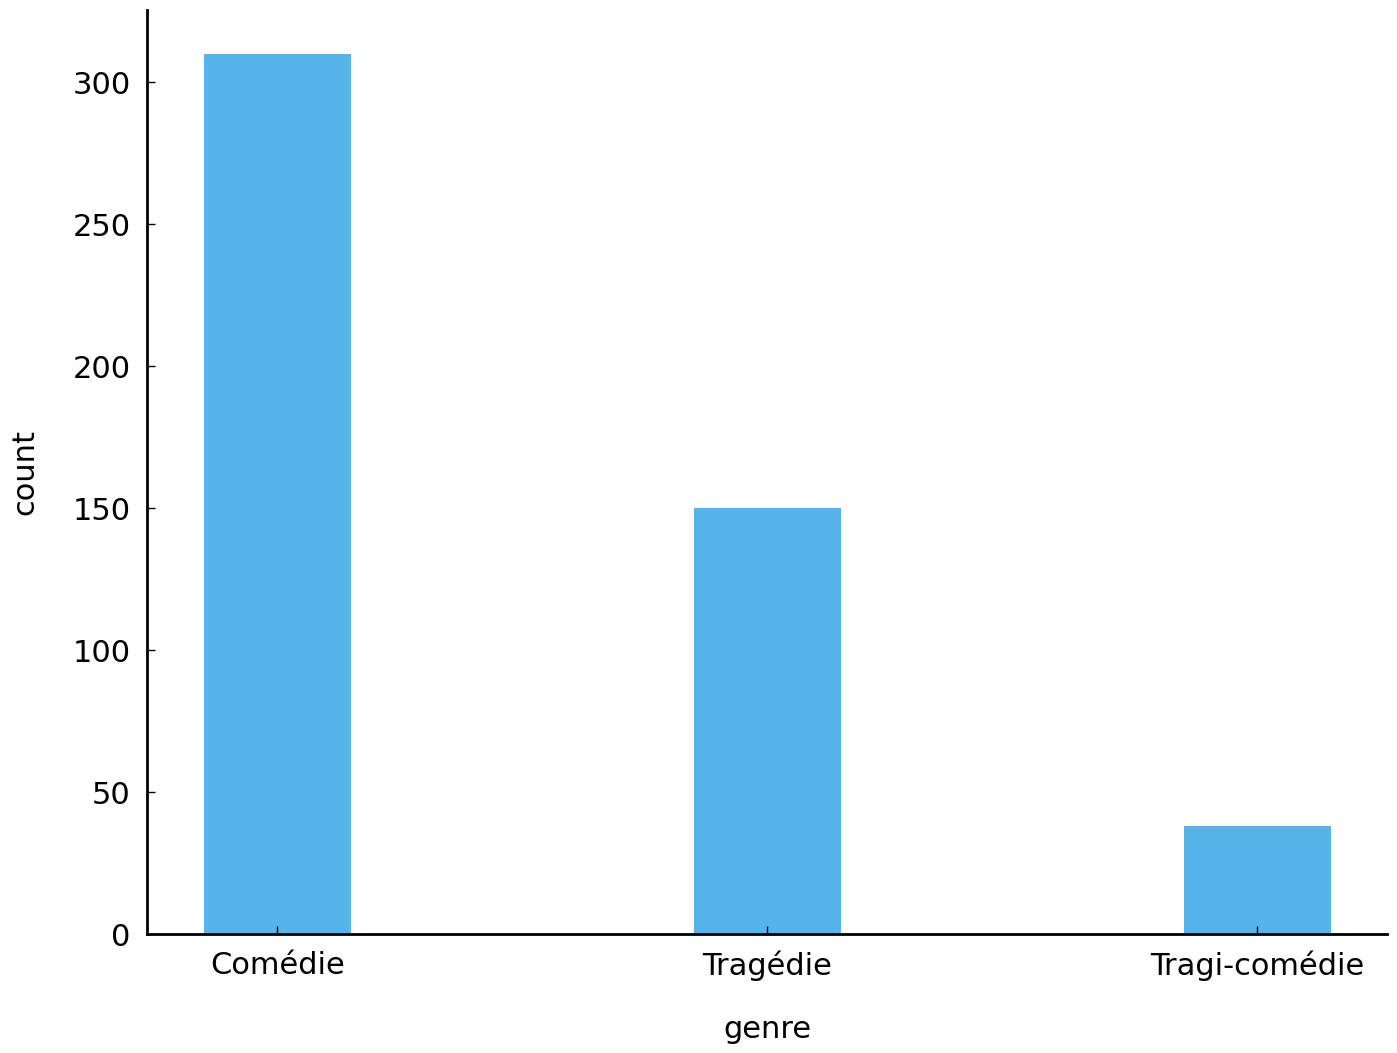

In [21]:
import matplotlib.pyplot as plt

counts = collections.Counter(genres)

fig, ax = plt.subplots()
ax.bar(counts.keys(), counts.values(), width=0.3)
ax.set(xlabel="genre", ylabel="count");

<!-- Figure: Distribution of dramatic subgenres in *Théâtre Classique*.\label{fig:vector-space:subgenre-distribution} -->

We clearly have a relatively skewed distribution: the most common genre of Comédies outnumbers the runner-up genre of Tragédies almost by two to one. The curious genre of Tragi-Comédies---the oxymoron in its name suggests it to be a curious mix of both Comédies and Tragédies---is much less common as a genre label in the dataset.

The apparent straightforwardness with which we have discussed <span class="index">literary genres</span> so far
is not entirely justified from the point of view of literary theory (see, e.g., {cite:t}`devitt:1993,stephens2013retelling`), and even cultural theory at large {cite:p}`chandler1997`. Although "genre" seems a (misleadingly) intuitive concept when talking about literature, it is also a highly vexed and controversial notion: genres are mere conventional tags that people use to refer to certain "text varieties" or "textual modes" that are very hard to delineate using explicit, let alone objective criteria. They are certainly not mutually exclusive---a "detective" can be a "romance" too---and they can overlap in complex hierarchies---a "detective" can be considered a hyponym of "thriller". Genre properties can moreover be extracted at various levels from texts, including style, themes, settings, and successful authors often like to blend genres (e.g., a "historical thriller"). Genre classifications therefore rarely go uncontested and their application can be a highly subjective matter, where personal taste or the paradigm a scholar works in will play a significant role. Because of the (inter)subjectivity that is involved in genre studies, quantitative approaches can offer a valuable second opinion on genetic classifications, like the one offered by Paul Fièvre. Are there any lexical differences between the texts in this corpus that would seem to correlate, or perhaps contradict, the classification proposed? Can the textual properties in a bag-of-words model shed new light on the special status of the Tragi-Comédies? And so on.

#### Exploring the corpus

After loading the plays into memory, we can transform the collection into a <span class="index">document-term matrix</span>. In the following code block, we first preprocess each play using the `preprocess_text()` function defined earlier, which returns a list of lowercase word tokens for each play. Subsequently, we construct the <span class="index">vocabulary</span> with `extract_vocabulary()`, and <span class="index">prune</span> all words that occur less than two times in the collection. The final step, then, is to assemble the document-term matrix by computing the token counts for all remaining words in the vocabulary for each document in the collection.

In [22]:
plays_tok = [preprocess_text(play, 'french') for play in plays]
vocabulary = extract_vocabulary(plays_tok, min_count=2)
document_term_matrix = np.array(corpus2dtm(plays_tok, vocabulary))

print(f"document-term matrix with "
      f"|D| = {document_term_matrix.shape[0]} documents and "
      f"|V| = {document_term_matrix.shape[1]} words.")

document-term matrix with |D| = 498 documents and |V| = 48048 words.


We are now ready to start our analysis: we have an efficient bag-of-words representation of a corpus in the form of a NumPy matrix (a two-dimensional array) and list of labels that unambiguously encodes the genre for each document vector in that table.

Let us start by naively plotting the available documents, as if the frequency counts for two specific words in our bag-of-words model were simple two-dimensional coordinates on a map. In previous work by {cite:t}`schoech:2017`, two words that had considerable discriminative power for these genres were "monsieur" (*sir*) and "sang" (*blood*), so we will use these as a starting point. We can select the corresponding columns from our <span class="index">document-term matrix</span>, by first retrieving their index in the vocabulary. The index of the words in our vocabulary is aligned with the indices of the corresponding columns in the bag-of-words table: we will therefore always use the index of an item in the vocabulary to retrieve the correct frequency column from the bag-of-words model. (The <span class="index">Pandas</span> library, which is discussed at length in chapter {ref}`chp-working-with-data`, simplifies this process considerably when working with so-called `DataFrame` objects.)

In [23]:
monsieur_idx = vocabulary.index('monsieur')
sang_idx = vocabulary.index('sang')

monsieur_counts = document_term_matrix[:, monsieur_idx]
sang_counts = document_term_matrix[:, sang_idx]

While NumPy is optimized for dealing with numeric data, lists of strings can also be
casted into <span class="index">array</span>s. This is exactly what we will do to our list
of genre labels too, in order to ease the process of retrieving the locations of specific genre labels in the list later on:

In [24]:
genres = np.array(genres)

The column vectors, `monsieur_counts` and `sang_counts`, both have the same length and
include the frequency counts for each of our two words in each document. Using the labels
in the corresponding list of genre tags, we can now plot each document as a point in the
two-dimensional space defined by the two count vectors. Pay close attention to the first
two arguments passed to the `scatter()` function inside the `for` loop in which we iterate
over the three genres: using the mechanism of "<span class="index">boolean
indexing</span>", we select the frequency counts for the relevant documents and we plot
those as a group in each iteration. The figure below is generated using the following code block:

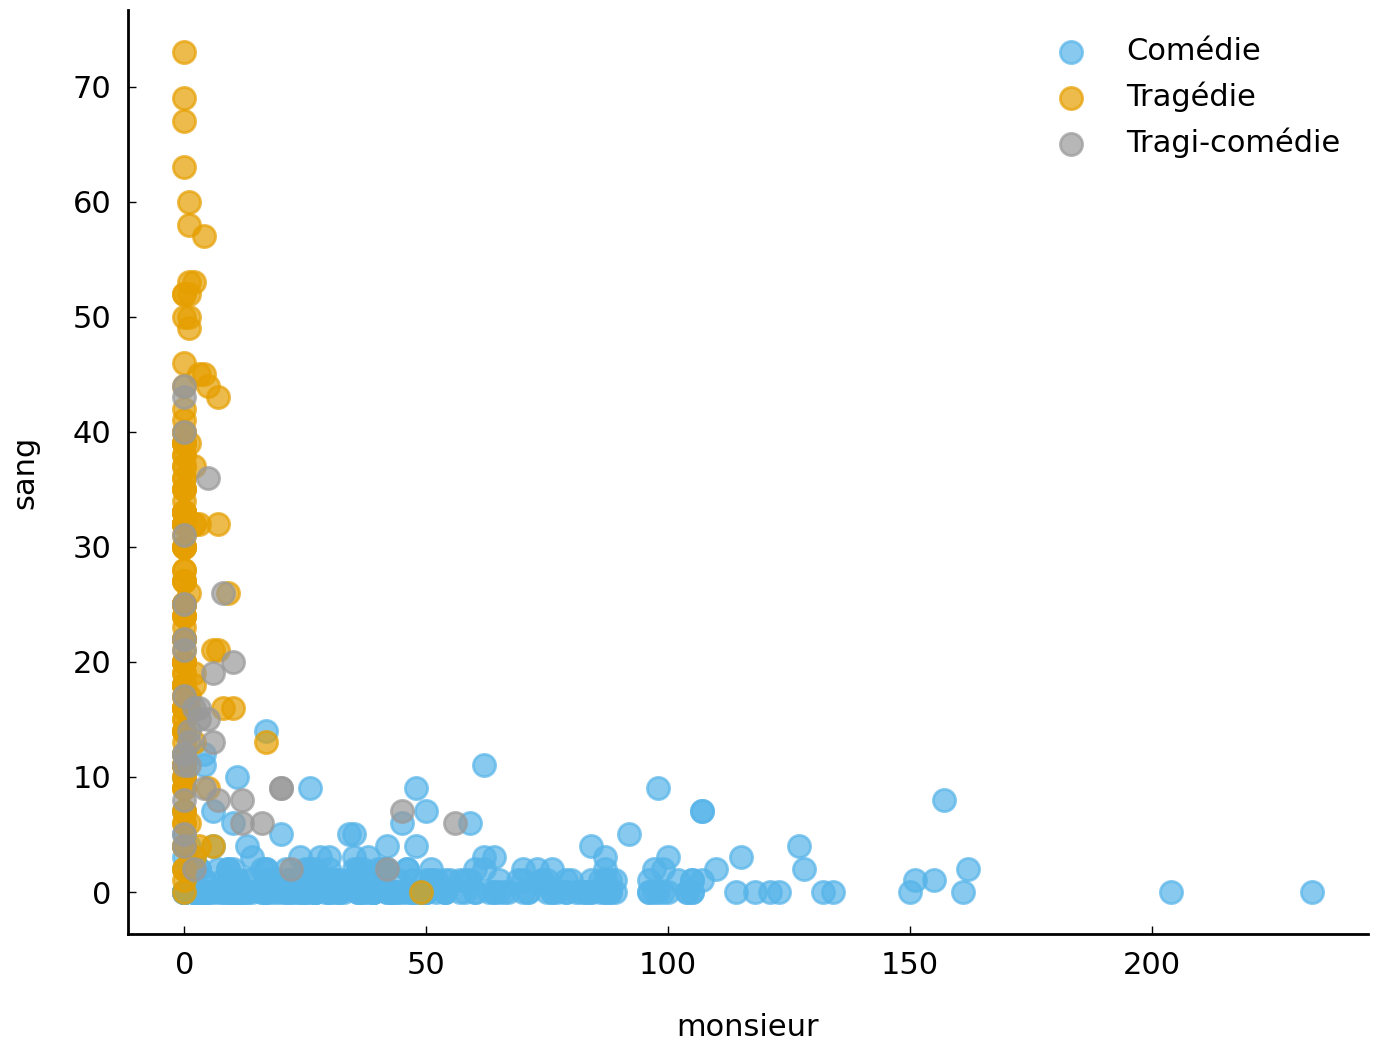

In [25]:
fig, ax = plt.subplots()

for genre in ('Comédie', 'Tragédie', 'Tragi-comédie'):
    ax.scatter(monsieur_counts[genres == genre],
               sang_counts[genres == genre],
               label=genre, alpha=0.7)

ax.set(xlabel='monsieur', ylabel='sang')
plt.legend();

<!-- Figure: Absolute frequency of "monsieur" and "sang" in individual plays.\label{fig:vector-space-models:monsieur-and-sang} -->

What does this initial "textual map" tell us? As we can glean from this plot, the usage of these two words appears to be remarkably distinctive. Many Tragédies seem to use the term "sang" profusely, whereas the term is almost absent from the Comédies. Conversely, the term "monsieur" is clearly favored by the authors of Comédies, where it is perhaps predominantly used as a vocative, because conversations are often said to be more typical of this particular subgenre {cite:p}`schoech:2017`. Interestingly, the Tragi-comédies seem to hold the middle between the other two genres, as these seem to invite much less extreme frequencies for those terms.

#### Genre vectors

Do we have any more objective methods to verify these impressions? A first option would be
to take a more aggregate view and look at the average usage of these term in the three
genres. In the code block below, we calculate the <span class="index">arithmetic
mean</span> or "<span class="index">centroid</span>s" for each genetic subcluster. This is
easy to achieve in <span class="index">NumPy</span>, which has a dedicated function for
this, <span class="index">`numpy.mean()`</span>, that we can apply to our entire bag-of-words model at once. Through setting the `axis` parameter to zero, we indicate that we are
interested in the column-wise mean (as opposed to, e.g., the row-wise mean for which we
could need to specify `axis=1`). 

```{warning} 
If this is all new to you, please study the materials in section {ref}`sec-vector-space-model-numpy-intro`.
```

Note how we again make use of the <span class="index">boolean indexing</span> mechanism to retrieve only the vectors accociated with the specific genre in each line below:

In [26]:
tr_means = document_term_matrix[genres == 'Tragédie'].mean(axis=0)
co_means = document_term_matrix[genres == 'Comédie'].mean(axis=0)
tc_means = document_term_matrix[genres == 'Tragi-comédie'].mean(axis=0)

The resulting mean vectors will hold a one-dimensional list or vector for each term in our vocabulary:

In [27]:
print(tr_means.shape)

(48048,)


We still can use the precomputed indices to retrieve the mean frequency of individual words from these summary vectors:

In [28]:
print('Mean absolute frequency of "monsieur"')
print(f'   in comédies: {co_means[monsieur_idx]:.2f}')
print(f'   in tragédies: {tr_means[monsieur_idx]:.2f}')
print(f'   in tragi-comédies: {tc_means[monsieur_idx]:.2f}')

Mean absolute frequency of "monsieur"
   in comédies: 45.46
   in tragédies: 1.20
   in tragi-comédies: 8.13


The mean frequencies for these words are again revealing telling differences across our
three genres. This also becomes evident by plotting the mean values in a scatter plot:

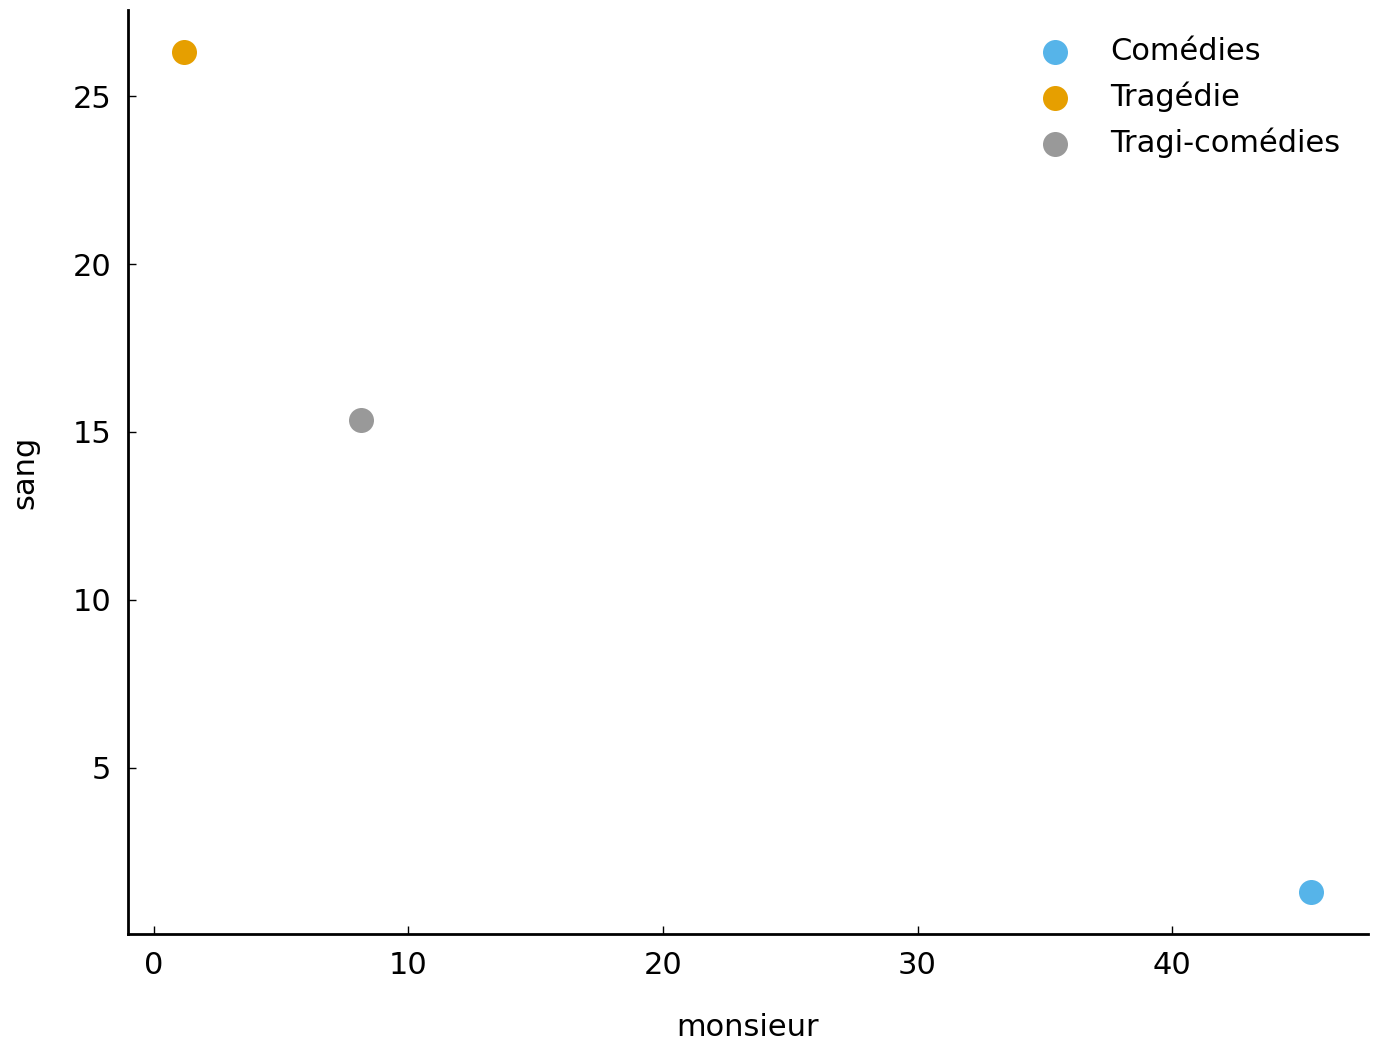

In [29]:
fig, ax = plt.subplots()

ax.scatter(
    co_means[monsieur_idx], co_means[sang_idx], label='Comédies')
ax.scatter(
    tr_means[monsieur_idx], tr_means[sang_idx], label='Tragédie')
ax.scatter(
    tc_means[monsieur_idx], tc_means[sang_idx], label='Tragi-comédies')

ax.set(xlabel='monsieur', ylabel='sang')
plt.legend();

<!-- Figure: Mean frequencies for *monsieur* and *sang* in Comédies, Tragédies, and Tragi-comédies.\label{fig:vector-space-model:mean-frequencies} -->

(sec-vector-space-model-distance-metrics)=
### Computing distances between documents

Let us pause for a minute and have a closer look at the simplified representation of our corpus in the form of the three centroids. The chapter set out to explore how we could apply spatial reasoning to texts using a bag-of-words model. In the space defined by this model, we should understand by now why documents with similar vector representations are closer to each other. The wager in the rest of this chapter will be that the <span class="index">geometric distance</span> between vectors can indeed serve as a proxy for human judgments of the dissimilarity of two documents. To put this into practice, a precise definition of distance in a vector space needs to be chosen. Let us review and illustrate a number of established methods to calculate the distance between document vectors and illustrate them on the basis of our three genre vectors. For the sake of simplicity, we define three vectors, one for each genre. We will use the points in this "mini" vector space to introduce a number of established distance metrics.

In [30]:
tragedy = np.array([tr_means[monsieur_idx], tr_means[sang_idx]])
comedy = np.array([co_means[monsieur_idx], co_means[sang_idx]])
tragedy_comedy = np.array([tc_means[monsieur_idx], tc_means[sang_idx]])

(sec-vector-space-model-euclidean-distance)=
#### Euclidean distance

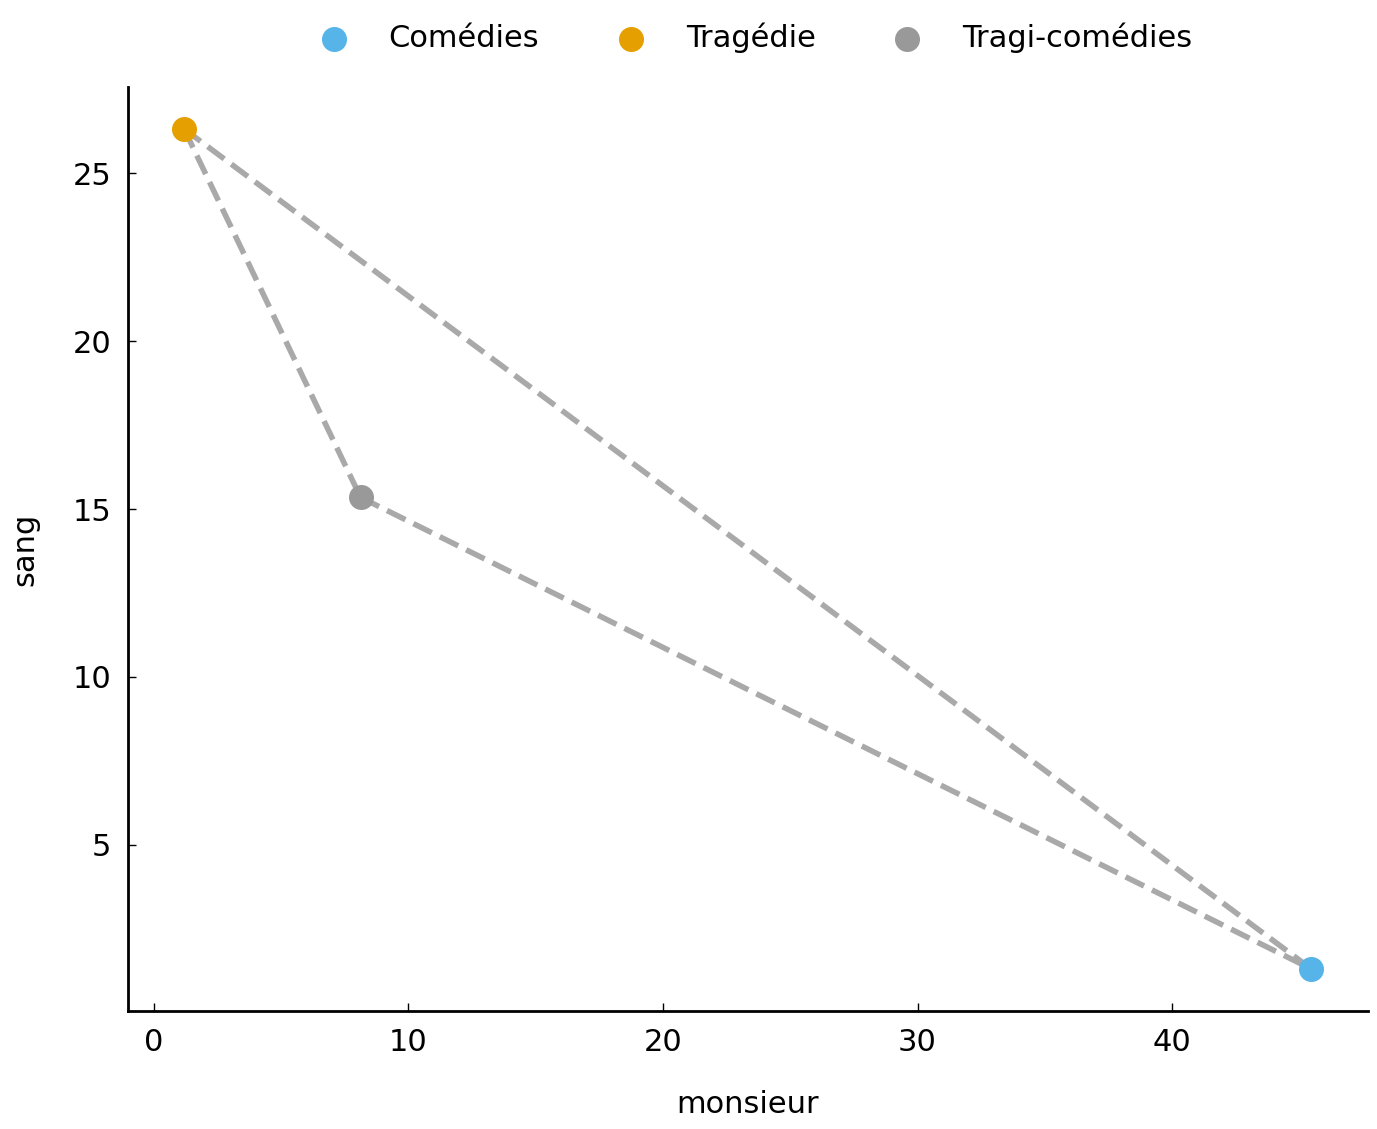

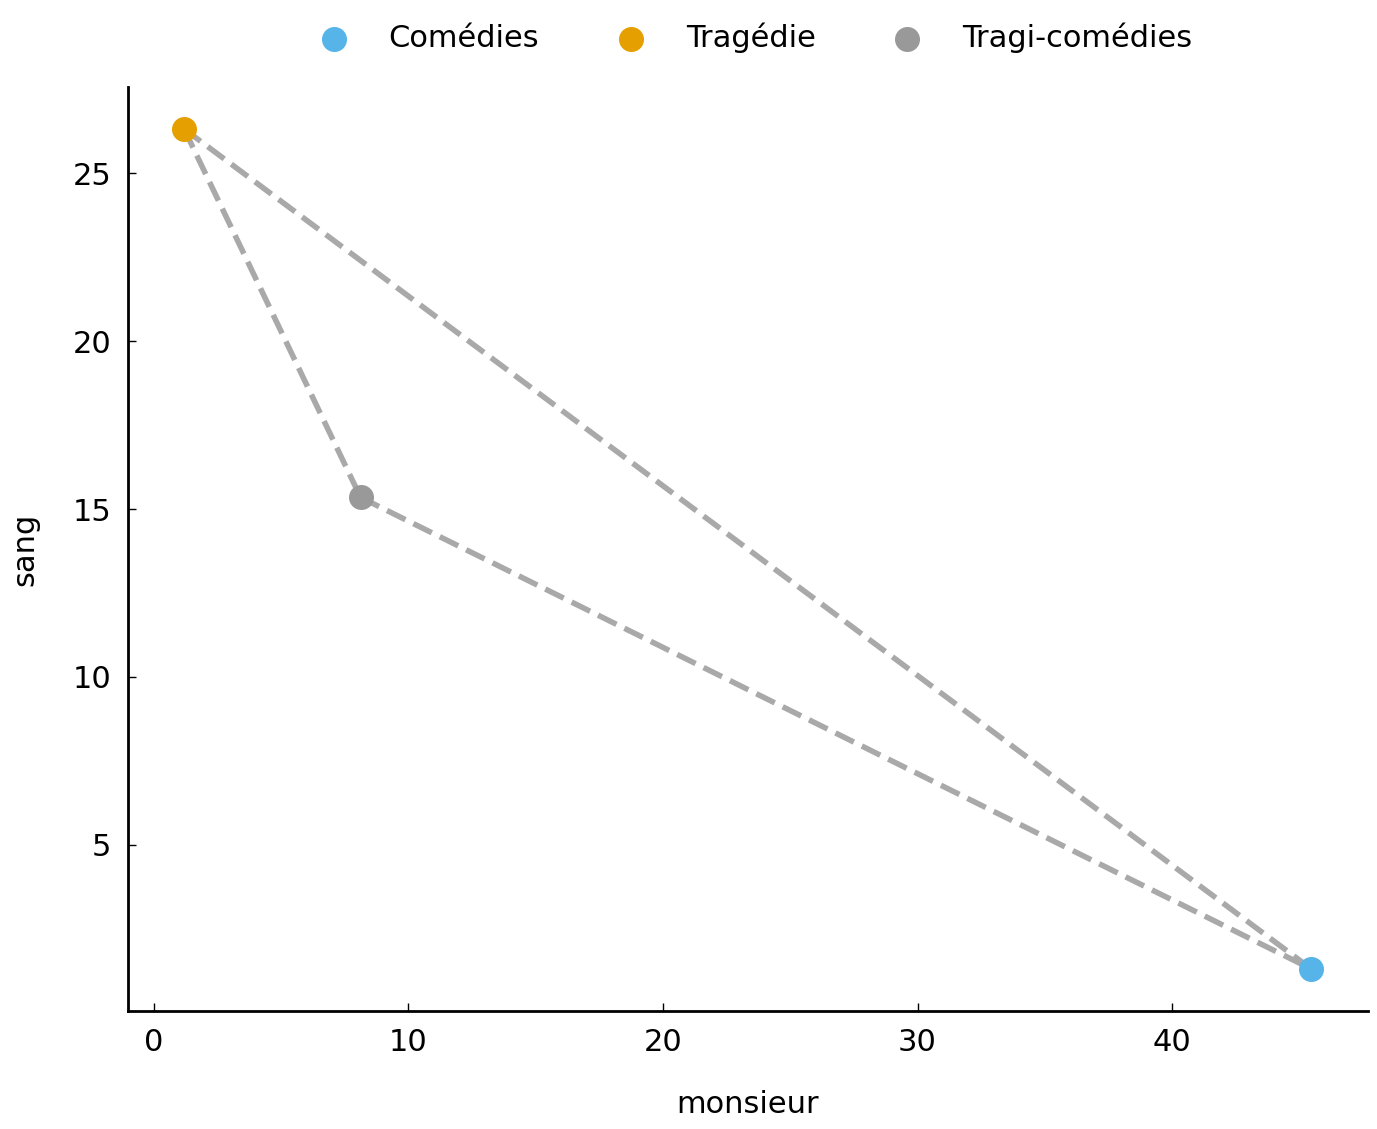

In [31]:
fig, ax = plt.subplots()

ax.plot([tr_means[monsieur_idx], tc_means[monsieur_idx]],
        [tr_means[sang_idx], tc_means[sang_idx]],
        'darkgrey', lw=2, ls='--')
ax.plot([tr_means[monsieur_idx], co_means[monsieur_idx]],
        [tr_means[sang_idx], co_means[sang_idx]],
        'darkgrey', lw=2, ls='--')
ax.plot([tc_means[monsieur_idx], co_means[monsieur_idx]],
        [tc_means[sang_idx], co_means[sang_idx]],
        'darkgrey', lw=2, ls='--')

ax.scatter(co_means[monsieur_idx], co_means[sang_idx],
           label='Comédies', zorder=3)
ax.scatter(tr_means[monsieur_idx], tr_means[sang_idx],
           label='Tragédie', zorder=3)
ax.scatter(tc_means[monsieur_idx], tc_means[sang_idx],
           label='Tragi-comédies', zorder=3)

ax.set(xlabel='monsieur', ylabel='sang')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3);
from myst_nb import glue
glue("euclidean_fig", fig, display=False)

```{glue:figure} euclidean_fig
:name: fig-vector-space-model-euclidean

Illustration for the Euclidean distance metric for the genre vectors.
```

Let us start with perhaps the most straightforward distance that is imaginable between two
points in space, namely, that of "as the crow flies". The <span class="index">Euclidean
distance</span> intuitively measures the length of the straight line which connects two
points. These straight lines are shown in grey in Figure
{numref}`fig-vector-space-model-euclidean`. Calculating the exact length of these lines
happens through the application of the Euclidean distance. Using mathematical notation, we
represent a vector as $\vec{x}$. Thus, given two vectors $\vec{a}$ and $\vec{b}$ with $n$ coordinates, the length of the line connecting two points is computed as follows:

\begin{equation}\label{eq:euclidean-distance}
d_2(\vec{a}, \vec{b}) = \sqrt{\sum^n_{i=1} (a_i - b_i)^2}
\end{equation}

Not everyone is familiar with these mathematical notations, so let us briefly explain how
to read the formula. First, $d_2$ is a function which takes two vectors, $\vec{a}$ and $\vec{b}$. Second, $\sum^n_{i=1}$ is a summation or sigma notation, which is a convenient notation for expressing the sum of the values of a variable. Here, the values are the squared differences between the $i$th value in vector $\vec{a}$ and the $i$th value in vector $\vec{b}$, i.e., $(a_i - b_i)^2$. We compute these differences for all $n$ coordinates (hence the little $n$ on top of the sigma sign; the expression $i=1$ underneath expresses that we start from the very first element in the series). Finally, we take the square root ($\sqrt{}$) of this sum. Sometimes, the details of formulas become clearer in the form of code. The formula for the Euclidean distance is relatively easy to translate to the following function in Python (which basically boils down to a single line, thanks to NumPy's conciseness):

In [32]:
def euclidean_distance(a, b):
    """Compute the Euclidean distance between two vectors.

    Note: ``numpy.linalg.norm(a - b)`` performs the
    same calculation using a slightly faster method.

    Arguments:
        a (numpy.ndarray): a vector of floats or ints.
        b (numpy.ndarray): a vector of floats or ints.

    Returns:
        float: The euclidean distance between vector a and b.

    Examples:
        >>> import numpy as np
        >>> a = np.array([1, 4, 2, 8])
        >>> b = np.array([2, 1, 4, 7])
        >>> round(euclidean_distance(a, b), 2)
        3.87

    """
    return np.sqrt(np.sum((a - b) ** 2))

In the code block below, we apply this <span class="index">distance metric</span> to the three pairwise combinations of our three vectors:

In [33]:
tc = euclidean_distance(tragedy, comedy)
print(f'tragédies - comédies:       {tc:.2f}')

ttc = euclidean_distance(tragedy, tragedy_comedy)
print(f'tragédies - tragi-comédies: {ttc:.2f}')

ctc = euclidean_distance(comedy, tragedy_comedy)
print(f' comédies - tragi-comédies: {ctc:.2f}')

tragédies - comédies:       50.84
tragédies - tragi-comédies: 12.98
 comédies - tragi-comédies: 39.89


The resulting distances clearly confirm our visual impression from the plot: the Tragi-comédies are relatively more similar to Tragédies (than Comédies), because the distance between the corresponding vectors is smaller in our example.

(sec-vector-space-model-cosine-distance)=
#### Cosine distance

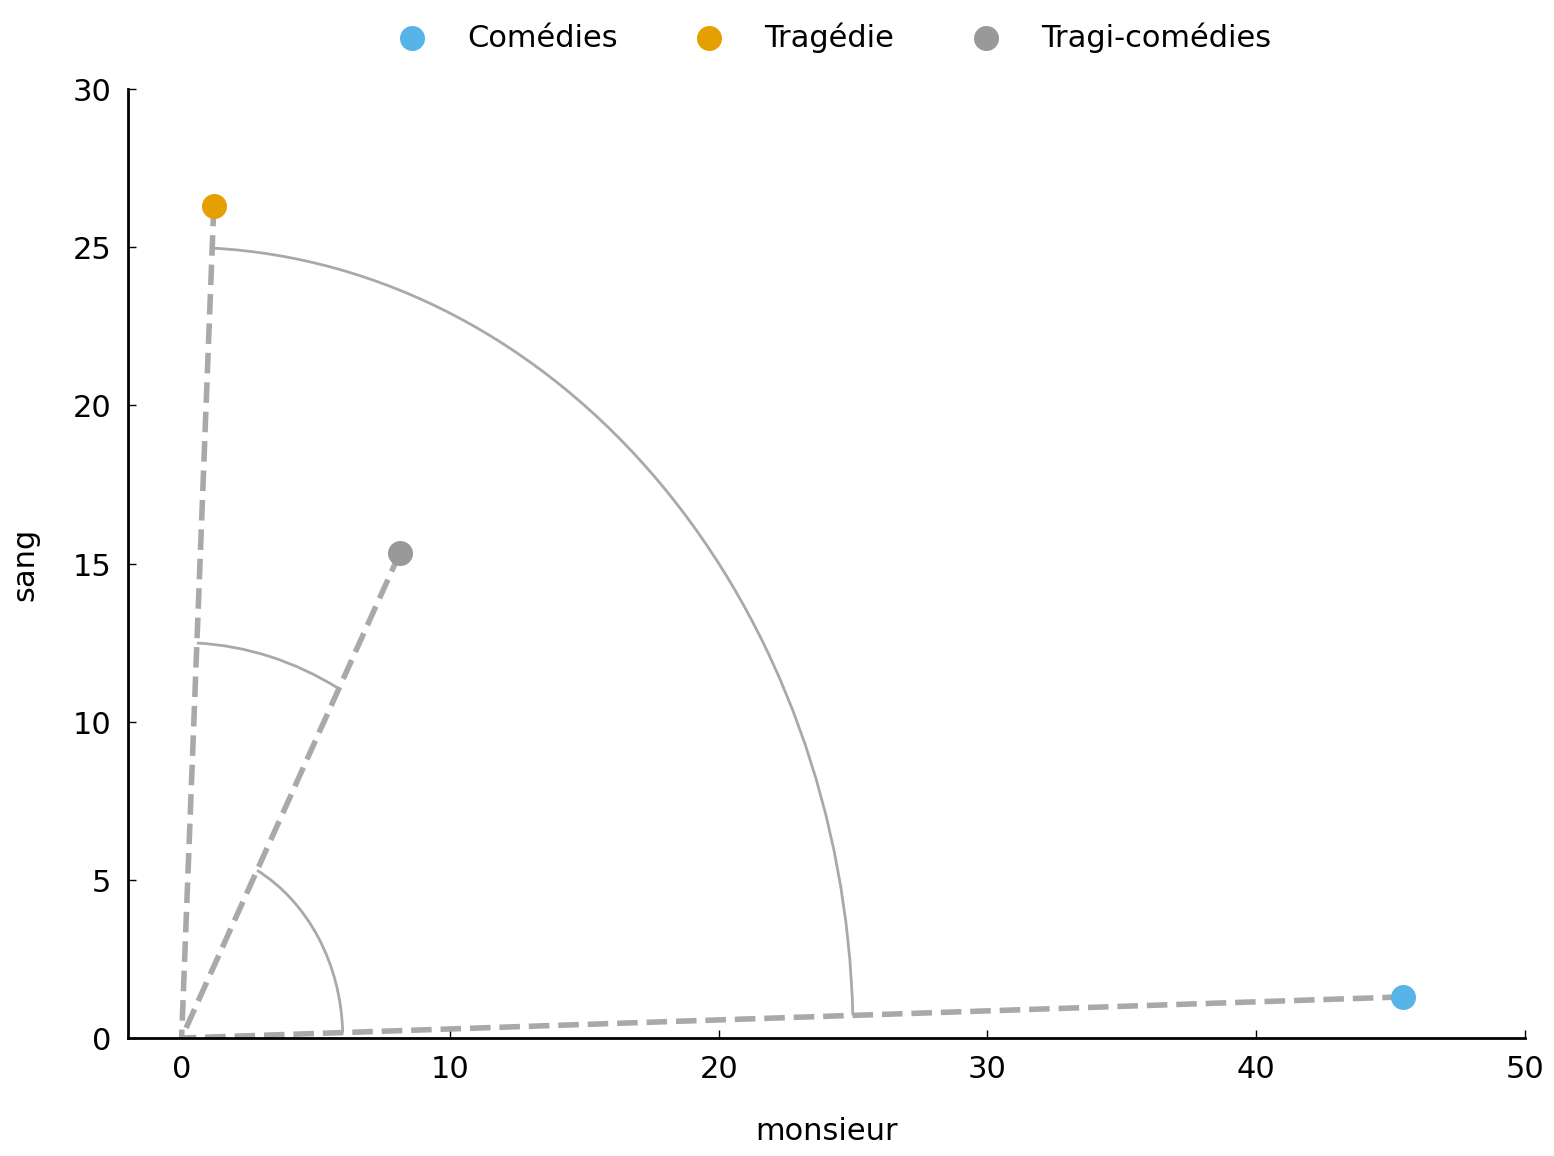

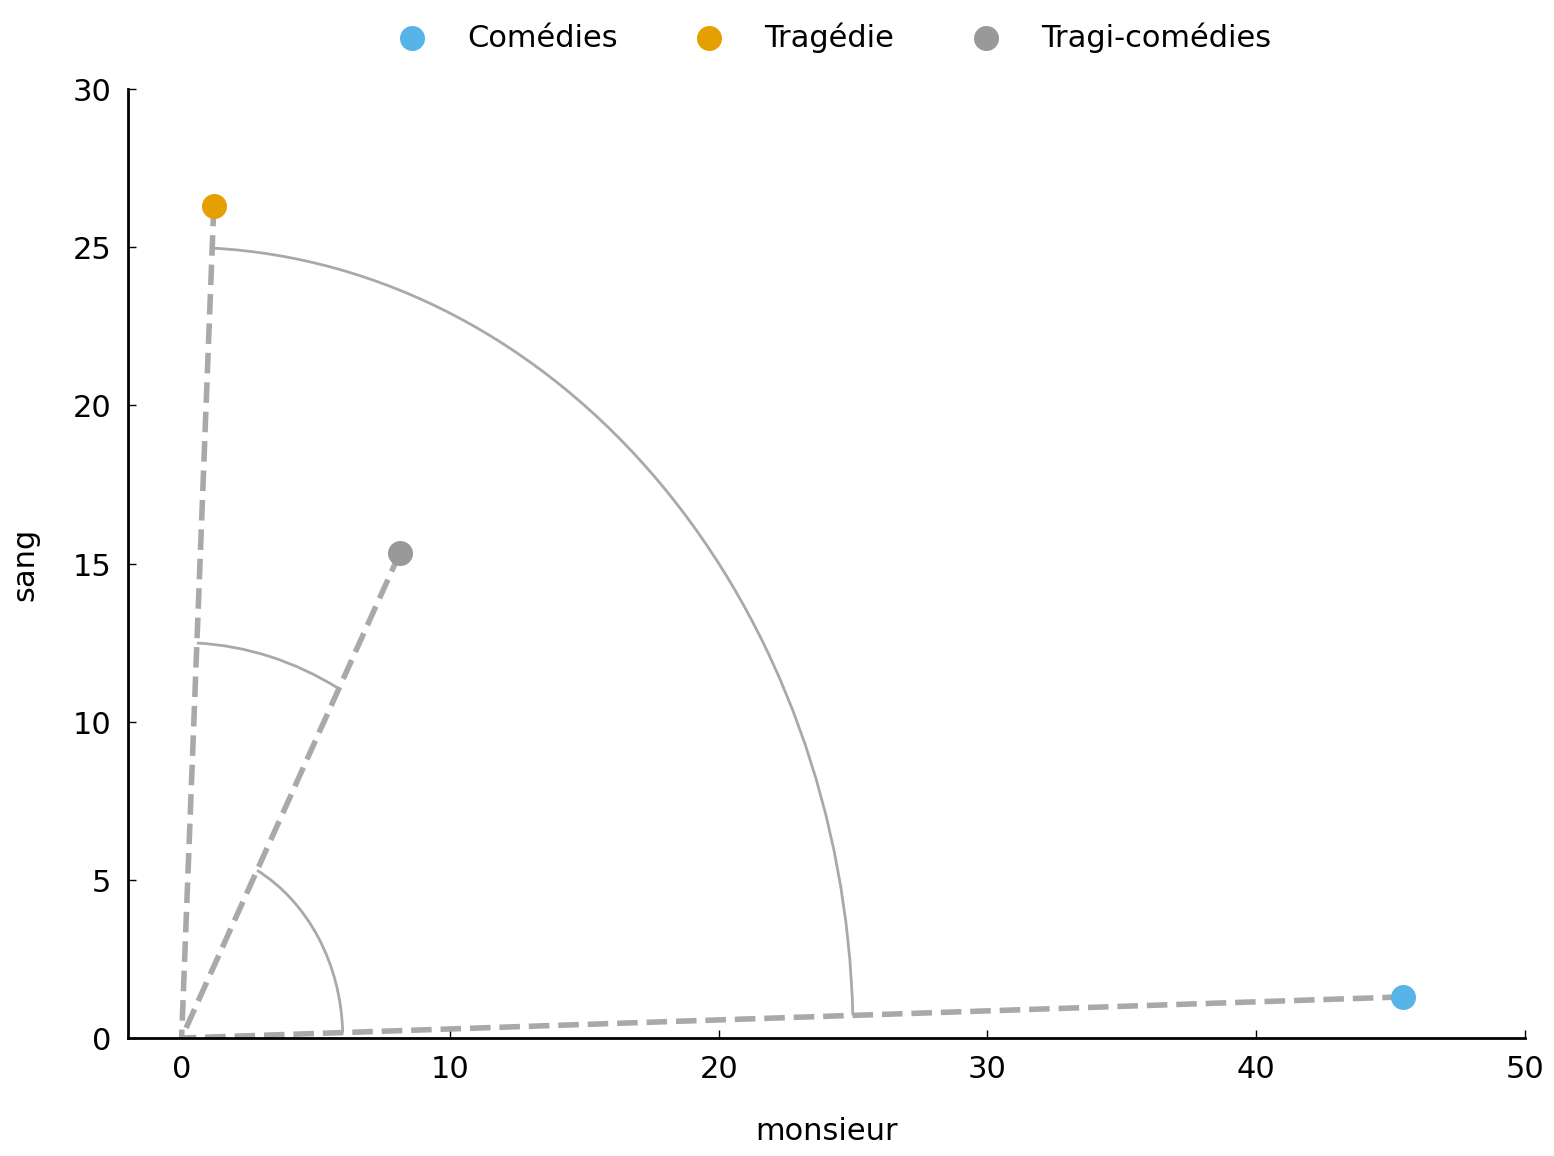

In [34]:
# following two blocks with much appreciated help from:
# https://stackoverflow.com/questions/25227100/best-way-to-plot-an-angle-between-two-lines-in-matplotlib
from matplotlib.lines import Line2D
from matplotlib.patches import Arc
import math

def get_angle_plot(line1, line2, offset = 1, color = None, origin = [0,0], len_x_axis = 1, len_y_axis = 1):

    l1xy = line1.get_xydata()

    # Angle between line1 and x-axis
    slope1 = (l1xy[1][1] - l1xy[0][1]) / float(l1xy[1][0] - l1xy[0][0])
    angle1 = abs(math.degrees(math.atan(slope1))) # Taking only the positive angle

    l2xy = line2.get_xydata()

    # Angle between line2 and x-axis
    slope2 = (l2xy[1][1] - l2xy[0][1]) / float(l2xy[1][0] - l2xy[0][0])
    angle2 = abs(math.degrees(math.atan(slope2)))

    theta1 = min(angle1, angle2)
    theta2 = max(angle1, angle2)

    angle = theta2 - theta1

    if color is None:
        color = line1.get_color() # Uses the color of line 1 if color parameter is not passed.

    return Arc(origin, len_x_axis*offset, len_y_axis*offset, 0, theta1, theta2, color=color)

fig, ax = plt.subplots()

ax.scatter(co_means[monsieur_idx], co_means[sang_idx],
           label='Comédies', zorder=3)
ax.scatter(tr_means[monsieur_idx], tr_means[sang_idx],
           label='Tragédie', zorder=3)
ax.scatter(tc_means[monsieur_idx], tc_means[sang_idx],
           label='Tragi-comédies', zorder=3)

# plot vectors
line_1 = Line2D([co_means[monsieur_idx], 0], [co_means[sang_idx], 0], 2, lw=2, ls='--', c='darkgrey')
line_2 = Line2D([tr_means[monsieur_idx], 0], [tr_means[sang_idx], 0], 1, lw=2, ls='--', c='darkgrey')
line_3 = Line2D([tc_means[monsieur_idx], 0], [tc_means[sang_idx], 0], 1, lw=2, ls='--', c='darkgrey')

ax = plt.gca()
ax.add_line(line_1)
ax.add_line(line_2)
ax.add_line(line_3)

angle_plot = get_angle_plot(line_1, line_2, 50)
ax.add_patch(angle_plot) # To display the angle arc

angle_plot = get_angle_plot(line_1, line_3, 12)
ax.add_patch(angle_plot) # To display the angle arc

angle_plot = get_angle_plot(line_2, line_3, 25)
ax.add_patch(angle_plot) # To display the angle arc

plt.xlabel('monsieur')
plt.ylabel('sang')
plt.ylim(0, 30)
plt.xlim(-2, 50)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.tight_layout()

from myst_nb import glue
glue("cosine_fig", fig, display=False)

```{glue:figure} cosine_fig
:name: fig-vector-space-model-cosine

Illustration for the cosine distance metric for the genre vectors.
```

An interesting alternative to the Euclidean distance, is the well-known <span
class="index">cosine distance</span> from geometry, which is perhaps the most widely
employed metric for computing dissimilarities between document vectors. When calculating
the distance between two documents in a space, the Euclidean distance plainly looks at the
exact coordinates of the two documents: it connects them with a straight line, so to
speak, and returns the length of that line. The cosine distance, however, takes a quite
different perspective on things: it is not primarily interested in those two *points* as
such, but it will interpret them as arrows or *vectors* that find their offset in the space's origin---these vectors are shown as dashed grey lines in {numref}`fig-vector-space-model-cosine`.

To estimate the similarity between two documents, the metric will measure the size of the angle between the two vectors that are defined by them. The similarity between two vectors is measured by the cosine of the angle between the two vectors, as the cosine of an angle increases as the angle decreases. Vectors pointing in the same direction (i.e., having a small angle between them) will, by this measure, be rated close to each other, even if the magnitude of the vectors is radically different and the length of the line connecting them is large.

The mathematical formula for calculating the cosine distance between two vectors $\vec{a}$ and $\vec{b}$ is slightly more involved:

\begin{equation}\label{eq:cosine-distance}
d_{\cos}(\vec a, \vec b) = 1 - \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
\end{equation}

Let us unpack this formula a little. The numerator in the fraction on the right involves a <span class="index">*dot product*</span>. This is the sum of multiplying each item in $\vec{a}$ with its corresponding item in $\vec{b}$, i.e.:

\begin{equation}\label{eq:dot-product}
\vec{a} \cdot \vec{b} = \sum^n_{i=1} a_i b_i = a_1 b_1 + a_2 b_2 + \ldots + a_n b_n
\end{equation}

With NumPy, the dot product can be calculated using <span class="index">`numpy.dot()`</span> (see below). In the denominator of the fraction, we see how the <span class="index">vector norm</span> (also called its length or its magnitude) is calculated for both $\vec{a}$ and $\vec{b}$, i.e., $|\vec{a}|$ and $|\vec{b}|$, and these numbers are then multiplied. The norm for a vector can be calculated using the following function:

In [35]:
def vector_len(v):
    """Compute the length (or norm) of a vector."""
    return np.sqrt(np.sum(v ** 2))

One aspect remains to be explained: the fraction in the formula gets subtracted from 1. Why is that? The fraction in the formula in fact corresponds to the cosine *similarity* (which will always lie between 0 and 1 for positive vectors). To turn this number into a distance, we take its complement, through subtracting it from 1.

With these insights, we are now equipped to implement a function which calculates the cosine distance between vectors:

In [36]:
def cosine_distance(a, b):
    """Compute the cosine distance between two vectors.

    Arguments:
        a (numpy.ndarray): a vector of floats or ints.
        b (numpy.ndarray): a vector of floats or ints.

    Returns:
        float: cosine distance between vector a and b.

    Note:
        See also scipy.spatial.distance.cdist

    Examples:
        >>> import numpy as np
        >>> a = np.array([1, 4, 2, 8])
        >>> b = np.array([2, 1, 4, 7])
        >>> round(cosine_distance(a, b), 2)
        0.09

    """
    return 1 - np.dot(a, b) / (vector_len(a) * vector_len(b))

We can again compute the distances between our vectors:

In [37]:
tc = cosine_distance(tragedy, comedy)
print(f'tragédies - comédies:       {tc:.2f}')

ttc = cosine_distance(tragedy, tragedy_comedy)
print(f'tragédies - tragi-comédies: {ttc:.2f}')

ctc = cosine_distance(comedy, tragedy_comedy)
print(f' comédies - tragi-comédies: {ctc:.2f}')

tragédies - comédies:       0.93
tragédies - tragi-comédies: 0.10
 comédies - tragi-comédies: 0.51


The cosine distances agree with their Euclidean counterparts: the resulting angle is relatively smaller between the Tragédies and the Tragi-comédies.

(sec-vector-space-model-cityblock-distance)=
#### City block distance

The <span class="index">city block distance</span> is a metric which computes the distance between two points in space as the sum of the absolute differences of their coordinates in space. (City block distance is also referred to as <span class="index">Manhattan distance</span> and $L_1$ distance.) To obtain an intuition of what this actually means in practice, consider the region of Manhattan shown in {numref}`fig-manhattan`.

```{figure} images/manhattan-turned.png
:name: fig-manhattan

Route between two locations on a map of Manhattan, NY.
```

Imagine standing at the intersection of 10th Avenue and 39th Street (location A) and you want to go for lunch somewhere at the intersection of 3rd Avenue and 47th Street (location B). How far is that? Ignoring the possibility of flying for the moment, you should follow the grid-like structure of Manhattan's streets. If you follow the route indicated on the map, you go 4 blocks east, 4 blocks north, another 5 blocks east, and, finally, yet another 5 blocks north. This sums to a total of 18 blocks, and, essentially, the city block distance is just that: the sum of the horizontal and vertical distance between two points. Let us describe this more formally. Given two points in space $a$ and $b$ with coordinates $a_1, a_2$, and $b_1, b_2$, respectively, the city block distance $d$ can be computed using the following equation:

\begin{equation}\label{eq:manhattan-example}
d_1(a, b) = |a_1 - b_1| + |a_2 - b_2|
\end{equation}

Plugging in the numbers from the Manhattan example, we obtain: $d_1(A, B) = |0 - 9| + |9 - 0| = 18$. Note that we need to compute the <span class="index">absolute difference</span> between two values (i.e. $|x - y|$), as the distance between two points can never be below zero---this is part of the definition of a <span class="index">*distance function*</span>. Just as with geographical landmarks, we can compute the <span class="index">city block distance</span> between two documents when they are represented as points in space. However, because document vectors usually consist of numerous dimensions, a more general formulation of the city block distance is required. Using the sigma notation ($\sum$), we can write the following:

\begin{equation}\label{eq:manhattan-distance}
d_1(\vec{a}, \vec{b}) = \sum^n_{i=1} |a_i - b_i|
\end{equation}

The formula can be implemented in Python as follows:

In [38]:
def city_block_distance(a, b):
    """Compute the city block distance between two vectors.

    Arguments:
        a (numpy.ndarray): a vector of floats or ints.
        b (numpy.ndarray): a vector of floats or ints.

    Returns:
        {int, float}: The city block distance between vector a and b.

    Examples:
        >>> import numpy as np
        >>> a = np.array([1, 4, 2, 8])
        >>> b = np.array([2, 1, 4, 7])
        >>> city_block_distance(a, b)
        7

    """
    return np.abs(a - b).sum()

How does this intuitively relate to our example with the vectors? Like in the case of the Manhattan street plan, we basically also project a grid onto our space, along both axes, and apply the same Manhattan-like reasoning. This is visualized in {numref}`fig-vector-space-model-cityblock`, where we plotted the individual paths between the data points.

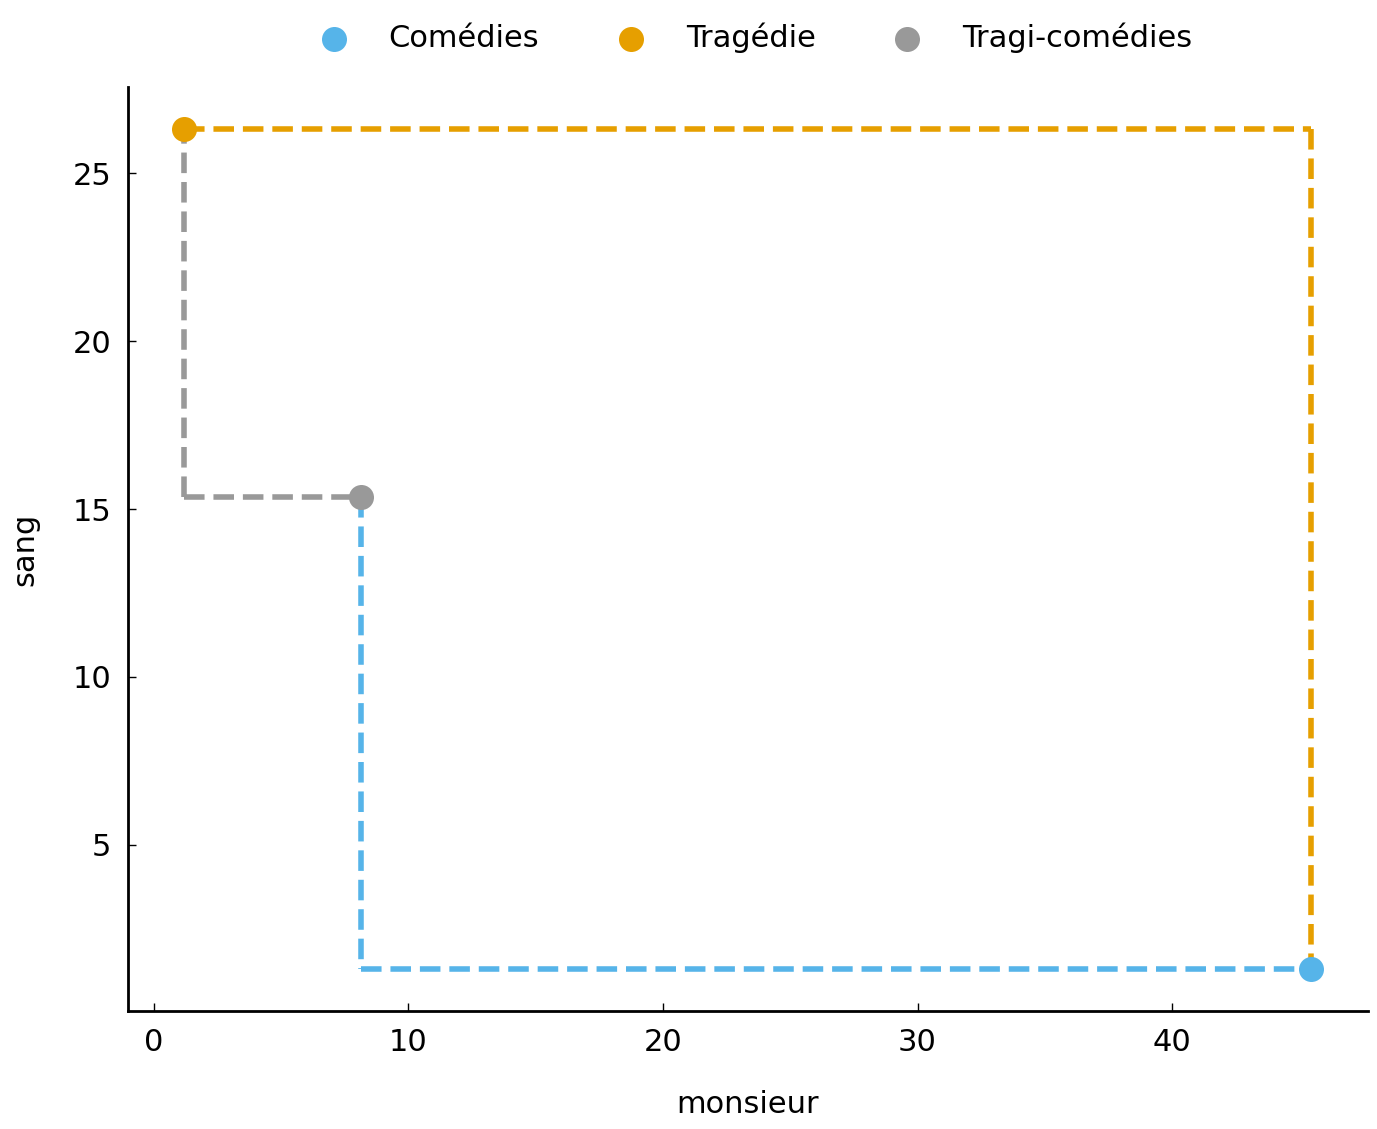

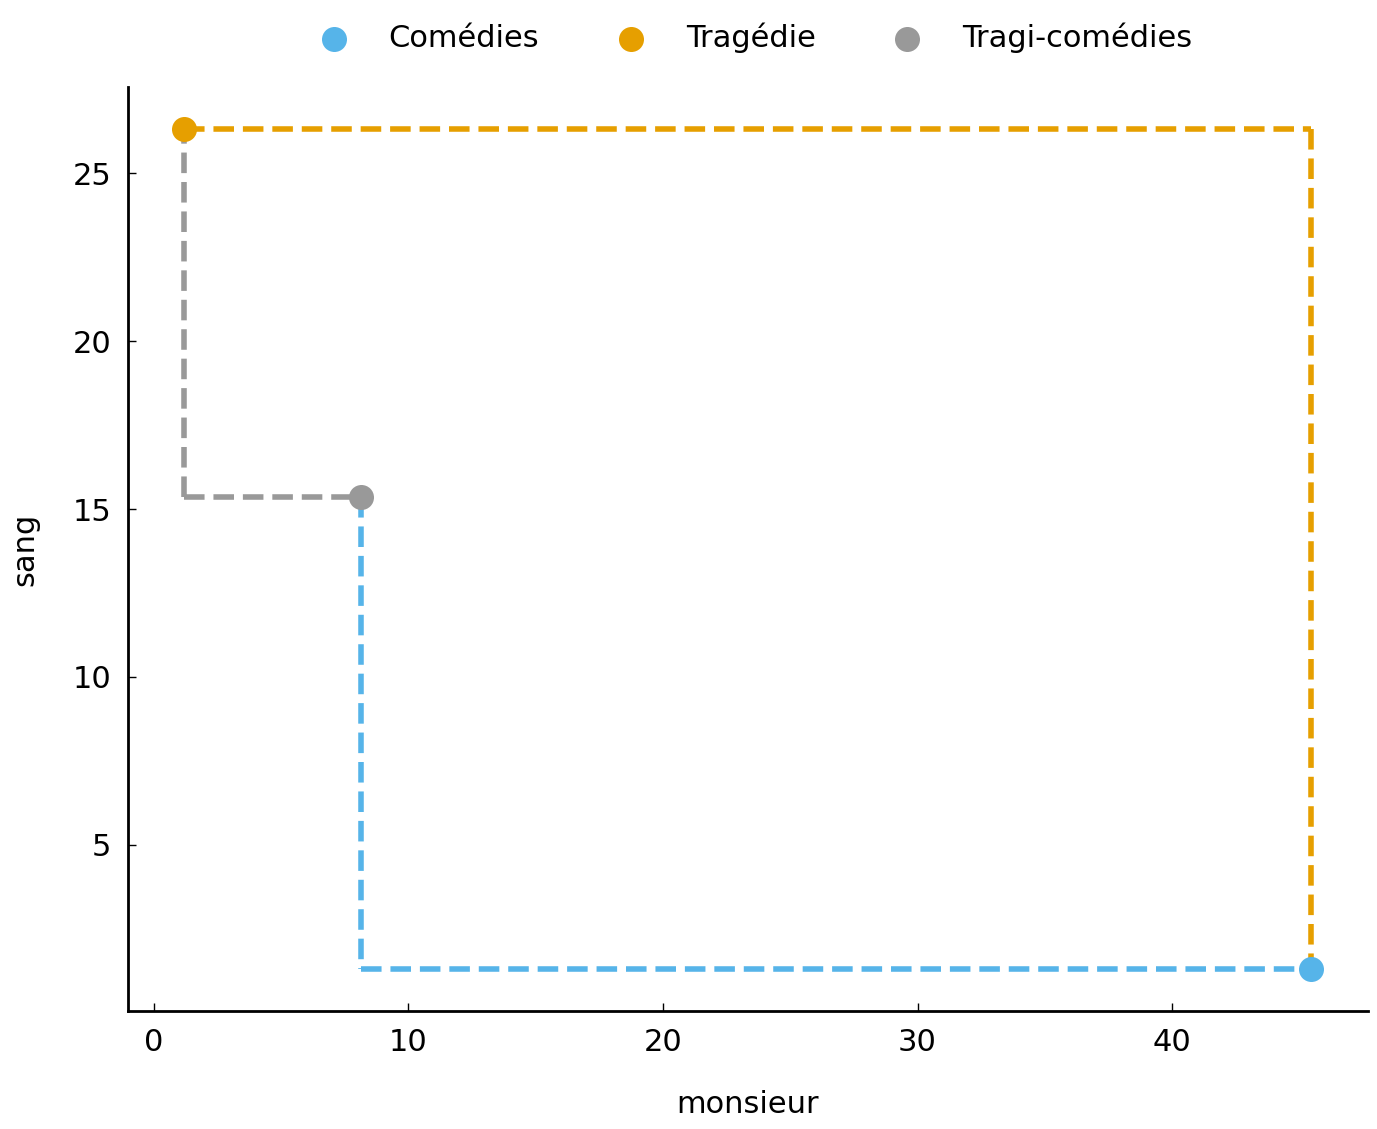

In [39]:
fig, ax = plt.subplots()

monsieur_trag = tr_means[monsieur_idx]
sang_trag = tr_means[sang_idx]
monsieur_com = co_means[monsieur_idx]
sang_com = co_means[sang_idx]
monsieur_tc = tc_means[monsieur_idx]
sang_tc = tc_means[sang_idx]


# trag-tc
ax.plot([monsieur_trag, monsieur_tc], [sang_tc, sang_tc],
        'C2', lw=2, ls='--')
ax.plot([monsieur_trag, monsieur_trag], [sang_tc, sang_trag],
        'C2', lw=2, ls='--')

# com-tc
ax.plot([monsieur_tc, monsieur_tc], [sang_tc, sang_com],
        'C0', lw=2, ls='--')
ax.plot([monsieur_tc, monsieur_com], [sang_com, sang_com],
        'C0', lw=2, ls='--')

# trag-com
ax.plot([monsieur_trag, monsieur_com], [sang_trag, sang_trag],
        'C1', lw=2, ls='--')
ax.plot([monsieur_com, monsieur_com], [sang_trag, sang_com],
        'C1', lw=2, ls='--')

ax.scatter(co_means[monsieur_idx], co_means[sang_idx],
           label='Comédies', zorder=3)
ax.scatter(tr_means[monsieur_idx], tr_means[sang_idx],
           label='Tragédie', zorder=3)
ax.scatter(tc_means[monsieur_idx], tc_means[sang_idx],
           label='Tragi-comédies', zorder=3)

ax.set(xlabel='monsieur', ylabel='sang')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3);

from myst_nb import glue
glue("cityblock_fig", fig, display=False)

```{glue:figure} cityblock_fig
:name: fig-vector-space-model-cityblock

Illustration for the cityblock distance metric for the genre vectors.
```

Because the <span class="index">city block distance</span> provides an entirely different view on the notion of distance, it is interesting to compare the intra-centroid distances yielded by this metric to the ones we obtained before:

In [40]:
tc = city_block_distance(tragedy, comedy)
print(f'tragédies - comédies:       {tc:.2f}')

ttc = city_block_distance(tragedy, tragedy_comedy)
print(f'tragédies - tragi-comédies: {ttc:.2f}')

ctc = city_block_distance(comedy, tragedy_comedy)
print(f' comédies - tragi-comédies: {ctc:.2f}')

tragédies - comédies:       69.28
tragédies - tragi-comédies: 17.90
 comédies - tragi-comédies: 51.38


The city block distance is a well-known distance function whose "inner workings" are not
too hard to understand. While it tends not to be used that frequently anymore in text
analysis, functions with a family resemblance to the city block distance do appear from
time to time. In the chapter on stylometry (Chapter {ref}`chp:stylometry`), for instance,
we will see that Burrows's popular Delta method is in fact a small variation on the city
block distance.

#### Comparing metrics

For the sake of simplicity, so far we have worked with the very limited example of our three genre vectors. The main issue with this dummy case is that we only considered a bidimensional vector space that consisted of two cherry-picked word variables that we already knew to be an important characteristic for some of the genres considered. For all other words in our vocabulary (that contains tens of thousands of terms), we simply do not know whether they show equally remarkable patterns. Would we see any different patterns if we applied these metrics on the entire vocabulary, also including words that might display less distinct usage across the three genres? Let us find out:

In [41]:
import scipy.spatial.distance as dist

genre_vectors = {'tragédie': tr_means, 'comédie': co_means, 'tragi-comédie': tc_means}
metrics = {'cosine': dist.cosine, 'manhattan': dist.cityblock, 'euclidean': dist.euclidean}

import itertools

for metric_name, metric_fn in metrics.items():
    print(metric_name)
    for v1, v2 in itertools.combinations(genre_vectors, 2):
        distance = metric_fn(genre_vectors[v1], genre_vectors[v2])
        print(f'   {v1} - {v2}: {distance:.2f}')

cosine
   tragédie - comédie: 0.04
   tragédie - tragi-comédie: 0.01
   comédie - tragi-comédie: 0.03
manhattan
   tragédie - comédie: 7147.79
   tragédie - tragi-comédie: 5169.42
   comédie - tragi-comédie: 8153.40
euclidean
   tragédie - comédie: 356.95
   tragédie - tragi-comédie: 250.69
   comédie - tragi-comédie: 505.08


This code block requires some additional explanation. We first import the <span class="index">SciPy</span> versions of the distance metrics which we hand-coded above. SciPy ("Scientific Python") is another influential package in the Python ecosystem that is predominantly relevant for scientific uses of the language. This is merely for illustration purposes, since these implementations should run perfectly parallel to our own. Next, we store both our genre vectors and our freshly imported functions in separate dictionaries for easy looping. Finally, we import the <span class="index">`itertools`</span> module from the standard library, which offers the function <span class="index">`itertools.combinations()`</span> for extracting all unique combinations between the elements of an iterable. The main goal of the block is to calculate the distances between all genre pairs in our data. Our earlier observation seems to be confirmed in this comparison: all metrics agree that the distance between the Tragédies and Tragi-comédies is relatively smaller than that between Comédies and Tragi-comédies, if we consider the complete vocabulary. However, there is also some interesting disagreement: for the cosine distance, the distance between Comédies and Tragi-comédies is smaller than the distance between Comédies and Tragédies, which is something that we do not see with the other metrics.

As we inspect the actual numbers returned by the distance metrics, we see that the city
block and Euclidean distances are huge in comparison to the cosine distance, which is
nicely clamped between 0 and 1. This is due to the fact that the cosine calculation
automatically normalizes the distance measure, using the magnitude-based denominator in
the fraction discussed above. Because the city block and Euclidean distance do not perform such a <span class="index">normalization</span>, they are much more sensitive to document length. Also, this explains why the cosine distance is nowadays commonly preferred in text analysis, since texts typically vary in length.

(sec-vector-space-model-nearest-neighbors)=
### Nearest neighbors

It seems logical that any text in a vector space will be surrounded by highly similar data points. Such clusters of similar data points might inform us about the behavior or characteristics of texts. Such an assumption is often referred to as a "local" form of reasoning, since we hypothesize that we can in fact characterize data points through inspecting (only) their immediate neighborhood, rather than the entire space at once. This leads us to an important concept in data analysis, namely that of the "<span class="index">nearest neighbor</span>". In the case of the French drama genres, for instance, one might expect that a Tragédie will always have another Tragédie as nearest neighbor -- and whenever this is not the case for a particular text, this might be an indication that this document deserves a closer look, since its behavior is unusual. As such, approaching our corpus with a nearest neighbor method might be an interesting way of performing "<span class="index">outlier detection</span>".

Below we define a function, `nearest_neighbors()`, that takes a document-term matrix as input. The function makes use of <span class="index">SciPy</span>'s <span class="index">`pdist`</span> function to compute the distances between all vectors. We use this function, because a more naive implementation, in which we iterate over the matrix's document vectors and returns for each item the index of its nearest neighbor, would be terribly slow. `pdist` returns a so-called "condensed <span class="index">distance matrix</span>", which we transform into a regular square-form distance matrix using the function <span class="index">`squareform`</span>. In such a square-form distance matrix, cells hold the distance between points $i$ and $j$. All distances at the diagonal (i.e., where $i = j$) of the matrix are zero, since these represent the distance between documents and themselves. To conveniently extract the nearest neighbor of each document, while ignoring the zeros at the diagonal, we first set all diagonal values to infinity. Subsequently, we can use NumPy's convenient <span class="index">`numpy.argmin()`</span> function, which returns the index of the minimal value in an array, i.e., the nearest neighbor.

In [42]:
def nearest_neighbors(X, metric='cosine'):
    """Retrieve the nearest neighbor for each row in a 2D array.

    Arguments:
        X (numpy.ndarray): a 2D array.
        metric (str): the distance metric to be used,
            one of: 'cosine', 'manhattan', 'euclidean'

    Returns:
        neighbors (list): A list of integers, corresponding to
            the index of each row's nearest neighbor.

    Examples:
        >>> X = np.array([[1, 4, 2], [5, 5, 1], [1, 2, 1]])
        >>> nearest_neighbors(X, metric='manhattan')
        [1, 0, 0]

    """
    distances = dist.pdist(X, metric=metric)
    distances = dist.squareform(distances)
    np.fill_diagonal(distances, np.inf)
    return distances.argmin(1)

In [43]:
neighbor_indices = nearest_neighbors(document_term_matrix)

From the array `genres`, we can retrieve the original genre labels assigned to each
document in the dataset. Then, using the indices which were returned by
`nearest_neighbors()`, we can look up the genres of each of their <span class="index">nearest neighbor</span>s:

In [44]:
nn_genres = genres[neighbor_indices]
print(nn_genres[:5])

['Comédie' 'Tragédie' 'Comédie' 'Comédie' 'Comédie']


What is the correspondence between the genres that were actually assigned to the items, and the genres of the nearest neighbors which were retrieved? We can quantify this correspondence through summing the number of overlapping label pairs in both arrays and dividing it by the total number of pairs. With NumPy, such operations are a walk through the park:

In [45]:
overlap = np.sum(genres == nn_genres)
print(f'Matching pairs (normalized): {overlap / len(genres):.2f}')

Matching pairs (normalized): 0.90


In approximately 90% of the cases, we see that the nearest neighbor of a text is indeed of
the same genre. This nearest neighbor approach allows us to reconsider our data set in a
variety of ways. With a <span class="index">`Counter`</span>, we can for instance inspect the distribution of genres in the list of nearest neighbors in each genre:

In [46]:
print(collections.Counter(nn_genres[genres == 'Tragédie']).most_common())
print(collections.Counter(nn_genres[genres == 'Comédie']).most_common())
print(collections.Counter(nn_genres[genres == 'Tragi-comédie']).most_common())

[('Tragédie', 130), ('Tragi-comédie', 16), ('Comédie', 4)]
[('Comédie', 298), ('Tragédie', 7), ('Tragi-comédie', 5)]
[('Tragi-comédie', 20), ('Tragédie', 10), ('Comédie', 8)]


The resulting distributions show which type of nearest neighbor is most commonly associated with each genre. Likewise, we could iterate over the Tragi-comédies, and calculate each text's distance to the mean of the other genre.

In [47]:
t_dists, c_dists = [], []
for tc in document_term_matrix[genres == 'Tragi-comédie']:
    t_dists.append(cosine_distance(tc, tr_means))
    c_dists.append(cosine_distance(tc, co_means))

print(f'Mean distance to comédie vector: {np.mean(c_dists):.3f}')
print(f'Mean distance to tragédie vector: {np.mean(t_dists):.3f}')

Mean distance to comédie vector: 0.060
Mean distance to tragédie vector: 0.042


Another option is to plot the resulting distances in a so-called "<span class="index">box plot</span>", that shows for each list a number of useful statistics, such as the median:

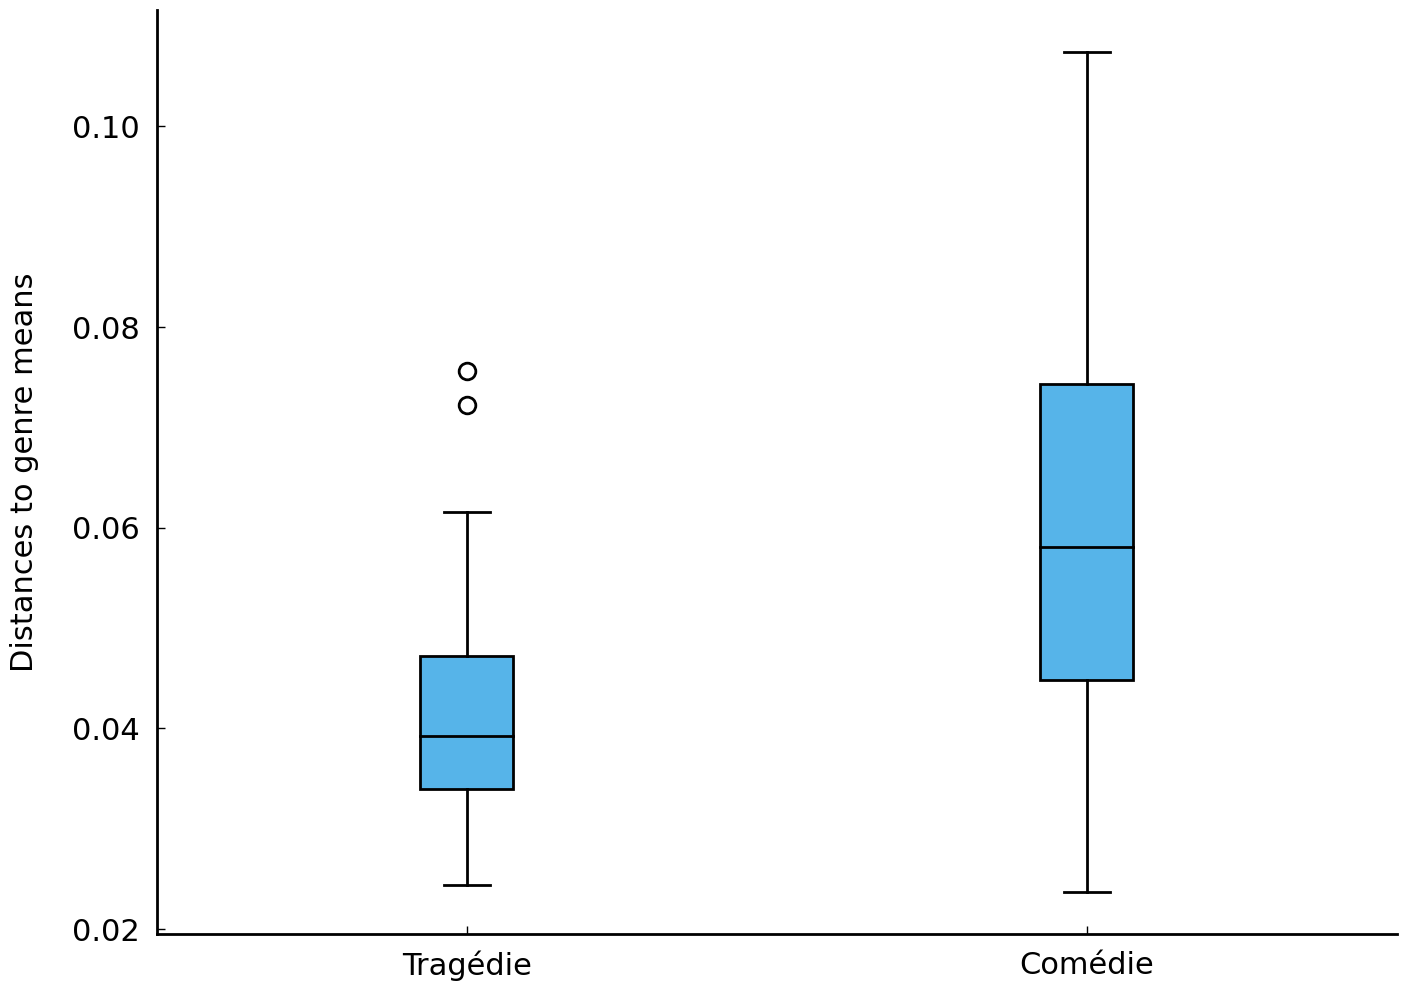

In [48]:
fig, ax = plt.subplots()
ax.boxplot([t_dists, c_dists])
ax.set(xticklabels=('Tragédie', 'Comédie'), ylabel='Distances to genre means');

<!-- Figure: Box plot of distances to genre means.\label{fig:vector-space-model:distance-to-centroids} -->

The Tragi-comédies' mean distance in the plot above are again relatively smaller to the
tragédies' genre vector in terms of their median distance. Any "<span
class="index">outliers</span>" in this plot are shown as individual data points that are
outside the "whiskers" (using empty circles by default). Two Tragi-comédies seem to show
an unexpectedly large distance to the tragedy centroid, with distance scores larger than
the 0.7. These unexpected outliers therefore invite a closer analysis, using more
conventional hermeneutic approaches. Retrieving the original titles of these outliers can
be done by first identifying the index of the two most extreme distances:

In [49]:
t_dists = np.array(t_dists)
outliers = t_dists.argsort()[::-1][:2]

Using a <span class="index">negative step index</span> (`[::-1]`), we invert the result of <span class="index">`numpy.argsort()`</span>, which defaults to an ascending order, whereas we are interested in the largest distances. Subsequently, we select the first two indices: our two outliers in the bar plot. Finally, we retrieve the original titles using these indices from the appropriate list of titles, which was extracted at the beginning of this chapter:

In [50]:
tc_titles = np.array(titles)[genres == 'Tragi-comédie']
print('\n'.join(tc_titles[outliers]))

STRATONICE, TRAGI-COMÉDIE
BÉRÉNICE, TRAGI-COMÉDIE EN PROSE.


For the second outlier, *Bérénice*, the plain fact that the text is in prose might explain the pronounced distance from the Tragédie centroid: Tragèdies in the corpus are mostly composed in verse -- although prose tragedies do occur, e.g., Voltaire's *Socrates* from 1759. The lack of (stereotypical) rhyme words, amongst other factors, is likely to cause lexical shifts in the vocabulary. For the *Stratonice* (1660) by Philippe Quinault, the first outlier, other explanatory grounds are called for, because this is a clear verse text. In this case, thematic divergence seems to have caused the lexical distance from the average tragedy. The classical material by Plutarch from which Quinault heavily borrowed in this play already possessed little "dramatic power" in the eyes of contemporaries {cite:p}`brooks:2009`. In fact, the only significantly dramatic scene which occurred in that material was deleted altogether in the *Stratonice*, which helps explain why it behaves as such an "un-tragedic" play in terms of word choice.

The fact that the *Stratonice* still received the (contemporary) label of Tragi-comédie illustrates that genre matters were as controversial a notion in seventeenth-century France as they are today. Some works in this period even attracted different genre labels across different editions of the very same text {cite:p}`hammond:2007`. Computational methods can help us model this genetic fluidity and make nuanced generalizations that would otherwise remain out of scope in humanistic research. Abstracting over the outliers discussed in the previous paragraph, all measurements above add (additional) quantitative evidence, for instance, for the existing view that the texts in the hybrid subgenre of Tragi-comédies are generally more similar to the typical tragedy than to the average comedy. As such, our results are congruent with what we know about the subgenre: Tragi-comédies are not comédies with some superficial tragic aspects thrown into the mix; rather at their core, they are tragedies to which some humorous twists were added to soften the dramatic aspects. A quantitative approach, however, does not only provide the means of confirmation regarding established views but also offers new methods to identify outliers which can help challenge and fine-tune existing perspectives in literary history.

(sec-vector-space-model-further-reading)=
## Further Reading

This chapter introduced the vector space model of texts and how representing texts as vectors can be used to quantify similarities between texts. We introduced a number of important text <span class="index">preprocessing</span> techniques and demonstrated the use of NumPy in this context, a library which provides data structures useful for storing and manipulating multidimensional numeric data. As a case study, we investigated a corpus of French plays from the Classical and Enlightenment period in France. Using the concept of distance metrics, we illustrated how the (dis)similarities between documents can be traced in a vector space. Likewise, the concept of a nearest neighbor proved a fruitful strategy to explore the morphology of our corpus -- and even detect outliers in it.

This chapter has laid much groundwork for some of the more advanced data analyses that will feature later on in the book. Preprocessing texts is required by almost all quantitative text analysis and subsequent chapters will often contain preprocessing blocks that are reminiscent of what we treated in this chapter. Likewise, the flexible manipulation of (vocabularies represented as) numeric data tables is foundational in data science. Nearest neighbor reasoning, finally, lies at the basis of a number of highly influential machine learning algorithms that can be used to automatically classify documents. In the chapter on stylometry, we will see how Burrows's Delta is in fact a simple variation on the nearest neighbors algorithm.

As will be clear by now, we often discuss implementations of certain basic algorithms in significant detail. This might seem superfluous: why recode a distance function from the ground up, if we can readily import a tried-and-tested implementation from a reference package like SciPy or NumPy? We insist on such low-level discussions, mainly because we believe that the black box is the biggest enemy of interpretative research. If we start to use (and accept) distance metrics as proxies for human judgment, it is important to have an understanding of -- and at least an intuition about -- how these distance metrics work internally, and which quantitative biases they come with.

A more detailed description of text preprocessing techniques is offered by {cite:t}`birdEA2009`, an updated version of which is available [online](http://www.nltk.org/book/). Thorough coverage of text normalization, including lemmatization and word stemming, can be found in chapter 2 of {cite:t}`jurafskyinpressspeech`. {cite:t}`vanderplas:2016` covers the ins and outs of working with NumPy. chapter 6 of {cite:t}`jurafskyinpressspeech` covers the vector space model and distance metrics. chapter 16 of {cite:t}`manning1999foundations` covers nearest neighbors classification. Those interested in the conceptual underpinnings of the vector space model may wish to consult an introduction to linear algebra such as {cite:t}`axler2004linear`.

## Exercises

In this chapter's exercises, we will employ the vector space model to explore a rich and
unique collection of '<span class="index">chain letters</span>', which were collected,
transcribed, and digitised by {cite:t}`vanarsdale:2019`. Here, we focus on one of the
largest chain letter categories: "luck chain letters". The recipients of these letters are
warned against sin, and the letters often contain prayers and emphasize good behavior according to Christian beliefs. The most characteristic and equally intriguing aspect of these chain letters is their explicit demand to be copied and redistributed to a number of successive recipients. If the recipient does not obey the letter's demands, and thus breaks the chain, he or she will be punished and bad fortune will be inevitable.

The following code block loads the corpus into memory. Two lists are created, one for the contents of the letters and one for their dating. The letters are loaded in chronological order.

In [51]:
import csv

letters, years = [], []
with open("data/chain-letters.csv") as f:
    reader = csv.DictReader(f)
    for row in reader:
        letters.append(row["letter"])
        years.append(int(row["year"]))

### Easy
1. Use the preprocessing functions from section
   {ref}`sec-vector-space-model-text-processing` to create (i) a tokenized version of the
   corpus, and (ii) a list representing the vocabulary of the corpus. How many unique
   words (i.e., word types) are there?
2. Transform the tokenized letters into a document-term matrix, and convert the matrix
   into a two-dimensional NumPy array. How many word tokens are there in the corpus?
3. What is the average number of words per letter? (Hint: use NumPy's `sum()` and `mean()` to
   help you with the necessary arithmetic.)

### Moderate
1. The length of the chain letters has changed considerably over the years. Compute the
   average length of letters from before 1950, and compare that to the average length of
   letters after 1950. (Hint: convert the list of years into a NumPy array, and use
   boolean indexing to slice the document-term matrix.)
2. Make a scatter plot to visualize the change in letter length over time. Add a label to
   the X and Y axis, and adjust the opacity of the data points for better
   visibility. Around what year do the letters suddenly become much longer?
3. Not only the length of the letters has changed, but also the contents of the letters.
   Early letters in the corpus still have strong religious undertones, while newer
   examples put greater emphasis on superstitious beliefs. (The Luck chain letter is
   generally believed to stem from the 'Himmelsbrief' (Letter from Heaven), which might
   explain these religious undertones.) {cite:t}`vanarsdale:2019` points to an interesting
   development of the postscript "It works!". The first attestation of this phrase is in
   1979, but in a few years time, all succeeding letters end with this statement. Extract
   and print the summed frequency of the words *Jesus* and *works* in letters written
   before and written after 1950.

### Challenging
1. Compute the cosine distance between the oldest and the youngest letter in the
   corpus. Subsequently, compute the distance between two of the oldest letters (any two
   letters from 1906 will do). Finally, compute the distance between the youngest two
   letters. Describe your results.
2. Use SciPy's `pdist()` function to compute the cosine distances between all letters in the
   corpus. Subsequently, transform the resulting condensed distance matrix into a regular
   square-form distance matrix. Compute the average distance between letters. Do the same
   for letters written before 1950, and compare their mean distance to letters written
   after 1950. Describe your results.
3. The function `pyplot.matshow()` in Matplotlib takes a matrix or an array as argument and
   plots it as an image. Use this function to plot a square-form distance matrix for the entire letter collection. To enhance your visualization, add a color bar using the function
   `pyplot.colorbar()`, which provides a mapping between the colors and the cosine
   distances. Describe the resulting plot. How many clusters do you observe?

---

(sec-vector-space-model-numpy-intro)=
## Appendix: Vectorizing Texts with NumPy

```{attention} 
Readers familiar with NumPy may safely skip this section.
```

<span class="index">NumPy</span> (short for Numerical Python) is the de facto standard library for scientific computing and data analysis in Python. Anyone interested in large-scale data analyses with Python is strongly encouraged to (at least) master the essentials of the library. This section introduces the essentials of constructing arrays (section {ref}`sec-vector-space-model-numpy-constructing-arrays`), manipulating arrays (section {ref}`sec-vector-space-model-indexing-and-slicing`), and computing with arrays (section {ref}`sec-vector-space-model-numpy-aggregating-functions`). A complete account of NumPy's functionalities is available in NumPy's online documentation.

(sec-vector-space-model-numpy-constructing-arrays)=
### Constructing arrays

NumPy's main workhorse is the N-dimensional array object <span class="index">`ndarray`</span>, which has much in common with Python's `list` type, but allows arrays of numerical data to be stored and manipulated much more efficiently. NumPy is conventionally imported using the alias <span class="index">`np`</span>:

In [52]:
import numpy as np

NumPy arrays can be constructed either by converting a `list` object into an array or by
employing routines provided by NumPy. For example, to initialize an array of floating points on the basis of a `list`, we write:

In [53]:
a = np.array([1.0, 0.5, 0.33, 0.25, 0.2])

Similarly, an array of integers can be created with:

In [54]:
a = np.array([1, 3, 6, 10, 15])

A crucial difference between NumPy arrays and Python's built-in `list` is that all items of a NumPy array have a specific and fixed type, whereas Python's `list` allows for mixed types that can be freely changed (e.g., a mixture of `str` and `int` types). While Python's dynamically typed `list` provides programmers with great flexibility, NumPy's fixed-type arrays are much more efficient in terms of both storage and manipulation. The data type of an array can be explicitly controlled for by setting the <span class="index">`dtype`</span> argument during initialization. For example, to explicitly set the data type for array elements to be 32-bit integers (sufficient for counting words in virtually all human-produced texts), we write the following:

In [55]:
a = np.array([0, 1, 1, 2, 3, 5], dtype='int32')
print(a.dtype)

int32


The trailing number 32 in `int32` specifies the number of bits available for storing the numbers in an array. An array with type `int8`, for example, is only capable of expressing integers within the range of -128 to 127. `int64` allows integers to fall within the range -9,223,372,036,854,775,807 to 9,223,372,036,854,775,807. (Python's native `int` has no fixed bounds.) The advantage of specifying data type is that doing so saves memory. The memory needed to store an integer of type `int8` amounts to a single byte, whereas those of type `int64` need 8 bytes. Such a difference might seem negligible, but once we start working with arrays which record millions or billions of term frequencies, the difference will be significant. As with integers, we can specify a type for floating numbers, such as `float32` and `float64`. Besides having a smaller memory footprint, numbers of type `float32` have a smaller precision than `float64` numbers. To change the data type of an existing array, we use the method <span class="index">`ndarray.astype()`</span>:

In [56]:
a = a.astype('float32')
print(a.dtype)

float32


NumPy arrays are explicit about their dimensions, which is another important difference between NumPy's `array` and Python's `list` object. The number of dimensions of an array is accessed through the attribute <span class="index">`ndarray.ndim`</span>:

In [57]:
a = np.array([0, 1, 1, 2, 3, 5])
print(a.ndim)

1


To construct a two-dimensional array, we pass a sequence of ordered sequences (i.e., a `list` or a `tuple`) to `np.array`:

In [58]:
a = np.array([[0, 1, 2], [1, 0, 2], [2, 1, 0]])
print(a.ndim)

2


Likewise, a sequence of sequences of sequences produces a three-dimensional array:

In [59]:
a = np.array([[[1, 3, 3], [2, 5, 2]], [[2, 3, 7], [4, 5, 9]]])
print(a.ndim)

3


In addition to an array's number of dimensions, we can retrieve the size of an array in each dimension using the attribute <span class="index">`ndarray.shape`</span>:

In [60]:
a = np.array([[0, 1, 2, 3], [1, 0, 2, 6], [2, 1, 0, 5]])
print(a.shape)

(3, 4)


As can be observed, for an array with 3 rows and 4 columns, the shape will be `(3, 4)`. Note that the length of the `shape` tuple corresponds to the number of dimensions, `ndim`, of an array. The `shape` of an array can be used to compute the total number of items in an array, by multiplying the elements returned by `shape` (i.e., 3 rows times 4 columns yields 12 items).

Having demonstrated how to create NumPy arrays on the basis of Python's `list` objects, let us now illustrate a number of ways in which arrays can be constructed from scratch using procedures provided by NumPy. These procedures are particularly useful when the shape (and type) of an array is already known, but its actual contents are yet unknown. In contrast with Python's `list`, NumPy arrays are not intended to be resized, because growing and shrinking arrays is an expensive operation. Fortunately, NumPy provides a number of functions to construct arrays of a predetermined size with initial placeholder content. First, we will have a look at the function <span class="index">`numpy.zeros()`</span>, which creates arrays filled with zeros (of type `float64` by default):

In [61]:
print(np.zeros((3, 5)))

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


The `shape` parameter of `numpy.zeros()` determines the shape of the constructed array. When `shape` is a single integer, a one-dimensional array is constructed:

In [62]:
print(np.zeros(10))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


The function <span class="index">`numpy.ones()`</span> and <span class="index">`numpy.empty()`</span> behave in a similar manner, with `numpy.ones()` creating arrays full of ones and `numpy.empty()` creating arrays as quickly as possible with no guarantee about their content.

In [63]:
print(np.ones((3, 4), dtype='int64'))

[[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]


In [64]:
print(np.empty((3, 2)))

[[0.0e+000 4.9e-324]
 [4.9e-324 9.9e-324]
 [1.5e-323 2.5e-323]]


Should an array filled with randomly generated values be desired, NumPy's submodule <span
class="index">`numpy.random()`</span> implements a rich variety of functions for producing
random contents. Here, we demonstrate a function to sample random floating point numbers
in the interval 0 to 1. The function works the same as before, and produces either
one-dimensional or multidimensional arrays depending on the size parameter:

In [65]:
print(np.random.random_sample(5))

[0.04289059 0.11546802 0.40834152 0.33923439 0.2435908 ]


In [66]:
print(np.random.random_sample((2, 3)))

[[0.2681808  0.25061548 0.45567564]
 [0.99833773 0.28882588 0.14021018]]


NumPy's counterpart of Python's `range` function is <span class="index">`numpy.arange()`</span>, which produces sequences of numbers as array objects. An interesting difference between `range` and `numpy.arange()` is that the latter accepts floats as arguments, which enables us to easily create floating-point sequences like the following:

In [67]:
a = np.arange(0, 2, 0.25)
print(a)

[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75]


(sec-vector-space-model-indexing-and-slicing)=
### Indexing and slicing arrays

Indexing and slicing NumPy arrays behaves similarly to accessing elements in Python's `list`. Accessing a single element from a one-dimensional array can be done by specifying its corresponding index within square brackets:

In [68]:
a = np.arange(10)
print(a[5])

5


Similarly, an array can be sliced to retrieve a sub-array, just as with Python's `list`:

In [69]:
print(a[3:8])

[3 4 5 6 7]


The strength of NumPy arrays becomes more evident in the context of multidimensional arrays. While Python's `list` and NumPy's 1-dimensional arrays allow for only a single index (or slice), multidimensional arrays allow for a (slice) index per dimension (sometimes called axis), separated by commas. This syntax provides a powerful mechanism to index and manipulate arrays. Let us start with a simple example. In the following code block, we retrieve the frequency of the word *monsieur* ("sir") from the third document. This is done by providing two indexes separated by a comma, of which the first corresponds to the row index of the third document, and the second points to the column of the word *monsieur*:

```{warning}
Here, we assume that you have executed all code in the chapter above up until (and
including) the code blocks in section {ref}`(sec-vector-space-model-mapping-genre)=`, so that you have
the object `document_term_matrix` available. 
```

In [70]:
word_index = vocabulary.index('monsieur')
document_term_matrix = np.array(document_term_matrix)
print(document_term_matrix[2, word_index])

17


Note that the order of these indexes corresponds to the shape of the `document_term_matrix`, in which the value at the first index indicates the number of documents, and the value in the second position counts the size of the vocabulary.

To retrieve the frequency of a given word for a sequence of documents, we use the Python slice convention in the first position. The following line retrieves an array consisting of the frequencies of *monsieur* in the first five documents of the document-term matrix:

In [71]:
print(document_term_matrix[:5, word_index])

[ 9  0 17  9 11]


Here, the left-hand side of the comma specifies a slice (i.e., the first five rows), and the index to the right of the comma indicates the column index (corresponding to *monsieur*). Similarly, to construct an array with frequencies for a number of specific columns, we can also use a slice index. Consider the following indexing operation, which constructs an array with counts corresponding to the words in columns 10 to 40 for the sixth document:

In [72]:
print(document_term_matrix[5, 10:40])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


To access all rows of a particular column (or collection of columns), we write the following:

In [73]:
column_values = document_term_matrix[:, word_index]

The same mechanism can be used to access all columns of a particular row (or collection of rows), as shown by the following:

In [74]:
print(document_term_matrix[5, :])

[0 0 0 ... 0 0 0]


When an array is indexed with less indexes than the array has dimensions, NumPy assumes the missing indexes to be complete. This is why the following less verbose (and common) notation is equivalent to the previous example:

In [75]:
print(document_term_matrix[5])

[0 0 0 ... 0 0 0]


In addition to indexing by integers and slices, NumPy offers a number of "fancy" indexing
techniques ("fancy" is, indeed, the common term for this form of indexing). We will
demonstrate two of them: (i) sequence indexing, and (ii) boolean indexing. Sequence
indexing is particularly useful when accessing discontinuous elements from an array. For
example, to construct an array with word counts for a few discontinuous documents, a
sequence of integers is given as a row index:

In [76]:
print(document_term_matrix[(1, 8, 3), :])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In a similar vein as the previous example, we can create a reduced array consisting of only a few columns. The following example shows how to construct a reduced array with word counts for the words *monsieur*, *madame*, and *amour*:

In [77]:
words = 'monsieur', 'madame', 'amour'
word_indexes = [vocabulary.index(word) for word in words]
print(document_term_matrix[:, word_indexes])

[[ 9  3  1]
 [ 0  0  3]
 [17  4  0]
 ...
 [ 4 35  7]
 [ 0  1 11]
 [ 0 31 15]]


We conclude this section with one final fancy indexing technique, <span class="index">*boolean indexing*</span>. Say we are interested in all plays in which the word *de* occurs. Using pure Python, we could solve this problem by iterating over all rows in `document_term_matrix` (see above) using a `for` loop, and check for each row if the column corresponding to *de* has a frequency higher than zero. Unfortunately, this strategy is rather inefficient and slow, especially for large lists of numbers. NumPy provides a much more efficient solution through its use of so-called "<span class="index">vectorized operation</span>s". But before we explain this solution, we first need to discuss the concept of vectorized operations. Consider the following list of numbers:

In [78]:
numbers = [0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55]

Imagine we want to update this list by multiplying each number by 10. In pure Python, a simple way to accomplish this is by means of a list comprehension, as shown in the following code block:

In [79]:
print([number * 10 for number in numbers])

[0, 10, 10, 20, 30, 50, 80, 130, 210, 340, 550]


Using NumPy's optimized vectorization mechanism, this can be rewritten to:

In [80]:
numbers = np.array(numbers)
print(numbers * 10)

[  0  10  10  20  30  50  80 130 210 340 550]


With this notation, Python's `for`-loop is replaced with an optimized operation written
using a lower-level programming language such as C. The performance difference between
pure Python and NumPy for this specific example may be barely noticeable. However, the
performance difference becomes increasingly important for larger lists of numbers.
IPython's "magic command" <span class="index">`%timeit`</span> enables us to conveniently time the speed of execution of a particular piece of code. Let us time the execution of multiplying a list of a million numbers by 10:

In [81]:
numbers = list(range(1000000))
%timeit [number * 10 for number in numbers]

62.5 ms ± 720 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The exact execution times may fluctuate from machine to machine, but execution times of the above example typically fall in the range of milliseconds. The timing for the same computation with NumPy's <span class="index">vectorized operation</span>s returns a much smaller number best described using *micro*seconds:

In [82]:
numbers = np.arange(1000000)
%timeit numbers * 10

1.37 ms ± 18 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Number comparisons (e.g., `5 < 10`) can also be vectorized. Say we have a list of numbers, and we want to filter all numbers smaller than 10. In Python, a solution to this problem could be implemented as follows:

In [83]:
numbers = [0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55]
print([number for number in numbers if number < 10])

[0, 1, 1, 2, 3, 5, 8]


Employing NumPy's vectorized number comparison operation, we can rewrite this to the following:

In [84]:
numbers = np.array(numbers)
print(numbers[numbers < 10])

[0 1 1 2 3 5 8]


How does this work? The part within square brackets (`numbers < 10`) performs a vectorized comparison operation, which returns a new array with boolean values representing the outcome (i.e., `True` or `False`) of the number comparison:

In [85]:
print(numbers < 10)

[ True  True  True  True  True  True  True False False False False]


We can use such a boolean array (a <span class="index">*mask*</span>) to select from the original array of numbers all elements associated with a `True` value. In other words, using a boolean array, we filter all numbers that pass the conditional expression. Let us now return to the problem of filtering the document-term matrix to include only texts in which the word *de* occurs at least once. The boolean indexing mechanism can be employed to retrieve these texts as follows:

In [86]:
print(document_term_matrix[document_term_matrix[:, vocabulary.index('de')] > 0])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(sec-vector-space-model-numpy-aggregating-functions)=
### Aggregating functions

We now proceed with a brief overview of some of the most important functions in NumPy used to
aggregate data, including functions for summing over values and finding the maxumum value in an array. Many of these are also provided as built-in functions in Python. However, just as with the vectorized operations discussed above, their NumPy counterparts are highly optimized and executed in compiled code, which allows for fast aggregating computations. To illustrate the performance gain of utilizing NumPy's optimized aggregation functions, let us start by computing the sum of all numbers in an array. This can be achieved in Python by means of the built-in function `sum()`:

In [87]:
numbers = np.random.random_sample(100000)
print(sum(numbers))

50193.84079530211


Summing over the values in `numbers` using NumPy is done using the function <span class="index">`numpy.sum()`</span> or the method `ndarray.sum()`:

In [88]:
print(numbers.sum())  # equivalent to np.sum(numbers)

50193.840795301425


While syntactically similar, NumPy's summing function is orders of magnitude faster than Python's built-in function:

In [89]:
%timeit sum(numbers)
%timeit numbers.sum()

6.1 ms ± 234 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


23 µs ± 602 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In addition to being faster, <span class="index">`numpy.sum()`</span> is designed to work with multidimensional arrays, and, as such, provides a convenient and flexible mechanism to compute sums along a given axis. First, we need to explain the concept of "<span class="index">axis</span>". A two-dimensional array, such as the document-term matrix, has two axes: the first axis (`axis=0`) runs vertically down the rows, and the second axis (`axis=1`) runs horizontally across the columns of an array. This is illustrated by {numref}`fig-vector-space-model-numpy-axis`.

```{figure} images/axis-hq.png
---
name: fig-vector-space-model-numpy-axis
width: 50%
---

Visualization of the axis ordering in two-dimensional NumPy arrays.
```

Under this definition, computing the sum of each row happens along the second axis: for each row we take the sum across its columns. Likewise, computing the sum of each column happens along the first axis, which involves running down its rows. Let us illustrate this with an example. To compute the sum of each row in the document-term matrix, or, in others words, the document lengths, we sum along the column axis (`axis=1`):

In [90]:
sums = document_term_matrix.sum(axis=1)

Similarly, computing the corpus-wide frequency of each word (i.e., the sum of each column) is done by setting the parameter `axis` to 0:

In [91]:
print(document_term_matrix.sum(axis=0))

[2 2 2 ... 4 3 2]


Finally, if no value to `axis` is specified, `numpy.sum()` will sum over all elements in an array. Thus, to compute to total word count in the document-term matrix, we write:

In [92]:
print(document_term_matrix.sum())

5356125


NumPy provides many other aggregating functions, such as <span class="index">`numpy.min()`</span> and <span class="index">`numpy.max()`</span> to compute the minimum/maximum of an array or along an axis, or <span class="index">`numpy.mean()`</span> to compute the arithmetic mean (cf. chapter {ref}`chp-statistics-essentials`). However, it is beyond the scope of this brief introduction into NumPy to discuss any of these functions in more detail, and for information we refer the reader to NumPy's excellent online documentation.

(sec-vector-space-model-array-broadcasting)=
### Array Broadcasting

In what preceded, we have briefly touched upon the concept of array arithmetic. We conclude this introduction into NumPy with a slightly more detailed account of this concept, and introduce the more advanced concept of "<span class="index">array broadcasting</span>", which refers to the way NumPy handles arrays with different shapes during arithmetic operations. Without broadcasting, array arithmetic would only be allowed when two arrays, for example $a$ and $b$, have exactly the same shape. This is required, because arithmetic operators are evaluated "element-wise", meaning that the operation is performed on each item in array $a$ and its corresponding item (i.e., with the same positional index) in array $b$. An example is given in the following code block, in which we multiply the numbers in array `a` with the numbers in array `b`:

In [93]:
a = np.array([1, 2, 3])
b = np.array([2, 4, 6])
print(a * b)

[ 2  8 18]


Essentially, array broadcasting provides the means to perform array arithmetic on arrays with different shapes by "stretching" the smaller array to match the shape of the larger array, thus making their shapes compatible. The observant reader might have noticed that we already encountered an example of array broadcasting when the concept of vectorized arithmetic operations was explained. A similar example is given by:

In [94]:
a = np.array([1, 2, 3])
print(a * 2)

[2 4 6]


In this example, the numbers in array `a` are multiplied by the scalar `2`, which, strictly speaking, breaks the "rule" of two arrays having exactly the same shape. Yet, the computation proceeds correctly, working as if we had multiplied ``a`` by ``np.array([2, 2, 2])``. NumPy's <span class="index">broadcasting</span> mechanism stretches the number `2` into an array with the same shape as array `a`. This stretching process is illustrated by {numref}`fig-vector-space-model-numpy-broadcasting`:

```{figure} images/broadcasting-simple-hq.png
---
name: fig-vector-space-model-numpy-broadcasting
width: 50%
---

Visualization of NumPy's broadcasting mechanism. Here the scalar 2 is stretched into an array with size 3.
```

Broadcasting operations are parsimonious, and avoid allocating intermediate arrays (e.g., `np.array([2, 2, 2])`) to perform the computation. However, conceptualizing array broadcasting as a stretching operation helps to better understand when broadcasting is applied, and when it cannot be applied. To determine whether or not array arithmetic can be applied to two arrays, NumPy assesses the compatibility of the dimensions of two arrays. Two dimensions are compatible if and only if (i) they have the same size, or (ii) one dimension equals 1. NumPy compares the shapes of two arrays element-wise, starting with the innermost dimensions, and then working outwards. Consider {numref}`fig-vector-space-model-broadcasting-matrix`, in which the upper half visualizes the multiplication of a $4 \times 3$ array by a one-dimensional array with 3 items.

```{figure} images/broadcasting-matrix-hq.png
---
name: fig-vector-space-model-broadcasting-matrix
width: 50%
---

Visualization of NumPy's broadcasting mechanism in the context of multiplying a two-dimensional array with a one-dimensional array. Here the one-dimensional array `[1, 2, 3]` is stretched vertically to fit the dimensions of the other array.
```

Because the number of items of the one-dimensional array matches the size of the innermost
dimension of the larger array (i.e., 3 and 3), the smaller 1 x 3 array can be broadcast
across the larger $4 \times 3$ array so that their shapes match (cf. the lower half of the
figure). Another example would be to multiply a $4 \times 3$ array by a $1 \times 4$
array. However, as visualized by {numref}`fig-vector-space-model-broadcasting-error`, <span class="index">array broadcasting</span> cannot be applied for this combination of arrays, because the innermost dimension of the left array (i.e., 3) is incompatible with the number of items of the one-dimensional array (i.e., 4). As a rule of thumb, one should remember that in order to multiply a two-dimensional array with a one-dimensional array, the number of items in the latter should match the outermost dimension of the former.

```{figure} images/broadcasting-error-hq.png
---
name: fig-vector-space-model-broadcasting-error
width: 50%
---

Visualization of the inapplicability of NumPy's broadcasting mechanism in the context of multiplying a one-dimensional array whose size mismatches the outermost dimension of a two-dimensional array.
```